**Instructions**

Getting the histogram for midline thal masks/clusters that made it to specific ROIs. We need bilateral masks ("#merging the bilateral masks") so as to avoid posterior thalamic features (ROIs). For 5 subjects. After that, look at which regions are consistently down/consistently up. Also, if some regions are *sometimes up*, include them. If some regions are *sometimes down*, do not include them. Make sure you are considering anatomical connections. If you can, get the average of the midline clusters for all the subjects (easier to look at the regions that made it to their target).  

In [1]:
from sklearn.cluster import KMeans
import nibabel as nb
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from nilearn import plotting
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plotting']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
subject_list = ['100307']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    root_dir = '/home/data/madlab/data/mri/hcp'

    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrack/hcp_thal_mask/' + subject_id + '/thal_seed/hcpprobX/thal_mask/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0])
    rh_mask = nb.load(glob(root_dir + '/probtrack/hcp_thal_mask/' + subject_id + '/thal_seed/hcpprobX/thal_mask/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])

    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data() #numpy array 1s and 0s
    lh_mask_data[:,0:60,:] = 0 
    #taking last slice and making 0 (check the number 79 but check saving and checking)
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    #hemi_mask = lh_mask_data + rh_mask_data
    
    #EDIT THIS to save mask temp to check if you cut off enough of the thalamus mask
    thal_mask = nb.Nifti1Image(lh_mask_data, hemi_affine, hemi_header) #add lines to save as file
    thal_mask_temp = '/scratch/madlab/crash/puck/{0}/hcp_thal_mask_{1}-clus.nii.gz'.format(subject_id,n_clus)
    #kmeans_file_dir = os.path.abspath(thal_mask_temp)
    #if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
    #    os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    #thal_kmeans_imag.to_filename(kmeans_file_dir)
    #Work on these above so you can see which slices to take off (maybe 5 maybe more) # Replace posterior slice values with 0
    
    
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrack/thalamus_25ksamp_avoidmask/' + '{0}/thal_seed/hcpprobX/targets/_pbx20/*nii.gz'.format(subject_id)) 
    rh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrack/thalamus_25ksamp_avoidmask/' + '{0}/thal_seed/hcpprobX/targets/_pbx21/*nii.gz'.format(subject_id)) 
    
    
    #merging and loading target files (producing an array of tuples!)
    #bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine

    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    
    #loading masked target seeds and turning 1D array into a matrix for non-zero values only
    #(hemi_mask x # of targ_files)
    
   #*************************new code 011821.... fix it 
    for hemi in ['0','1']:
        if hemi == '0':
            out_file = os.path.join(os.getcwd(), 'kmeans_thallh_{0}-clus.nii.gz'.format(n_clus))
            curr_hemi_mask = thal_mask[0]
        else:
            out_file = os.path.join(os.getcwd(), 'kmeans_thalrh_{0}-clus.nii.gz'.format(n_clus))
            curr_hemi_mask = thal_mask[1]
        
        # Use the mask image to get some information about the dimensions of the data
        # Affine, header, etc... for later saving and reshaping
        hemi_mask_img = nib.load(curr_thal_mask)
        hemi_mask_data_affine = hemi_mask_img.affine
        hemi_mask_data_header = hemi_mask_img.header
        hemi_mask_data = hemi_mask_img.get_data()
        hemi_mask_data_dims = hemi_mask_data.shape
        
        # Replace posterior slices of mask with 5 to not analyze
        # voxels that are physically adjacent to the hippocampus
        # these voxels will have artifically inflated target hits.
        hemi_mask_data[:,0:75,:] = 0
    #************************end new code 011821.... fix it 
    
    #creates an feature by voxel array
    curr_hemi_thal_mask = curr_hemi_mask.get_data()
    for i,  curr_targ_file in enumerate(targ_file_list):
            curr_targ = nb.load(curr_targ_file)
            curr_targ_thalonly_data = curr_targ.get_data()[curr_hemi_thal_mask > 0] 
            curr_targ_thalonly_data_col = curr_targ_thalonly_data.reshape(np.sum(curr_hemi_thal_mask),1) 
            if i == 0:
                alltarg_thalonly_img_data = curr_targ_thalonly_data_col
            else:
                alltarg_thalonly_img_data = np.concatenate((alltarg_thalonly_img_data, curr_targ_thalonly_data_col),1)
            

    #creates an feature by voxel array 
    #input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) for lh, rh in bilat_targ_files], axis = 1)
    #gives 3 dimensions to put it back into brain space
    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(alltarg_thalonly_img_data) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/hcp_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [36]:
###########################OLD############################################

In [33]:
#plotting.plot_img(lh_mask_data)

**Subject 100307**

In [18]:
subject_list = ['100307']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8

    root_dir = '/home/data/madlab/data/mri/hcp'
    
    #NEED TO MAKE THESE PR
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrack/hcp_thal_mask/'  + subject_id + 
                           '/thal_seed/hcpprobX/thal_mask/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0])
    rh_mask = nb.load(glob(root_dir + '/probtrack/hcp_thal_mask/'  + subject_id + 
                           '/thal_seed/hcpprobX/thal_mask/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
   
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data

    
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrack/thalamus_25samp_avoidmask/' +
                '{0}/thal_seed/hcpprobX/targets/_pbx20/*nii.gz'.format(subject_id)) 
    rh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrack/thalamus_25samp_avoidmask/' +
                '{0}/thal_seed/hcpprobX/targets/_pbx21/*nii.gz'.format(subject_id)) 
    
    
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/hcp_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

IndexError: list index out of range

In [5]:
lh_targ_files

[]

In [ ]:
fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [2]:
subject_list = ['100307']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8

    root_dir = '/home/data/madlab/data/mri/hcp'
    
    #NEED TO MAKE THESE PR
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask' 
                + subject_id + '/thal_seed/hcpprobX/'
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) 
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
   
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrck/thalamus_25samp_avoidmask/' +
                '{0}/thal_seed/hcpprobX/targets/_pbx20/*nii.gz'.format(subject_id)) 
    rh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrck/thalamus_25samp_avoidmask/' +
                '{0}/thal_seed/hcpprobX/targets/_pbx21/*nii.gz'.format(subject_id)) 

    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

IndexError: list index out of range

In [3]:
print(all_thal_features_z[[5]])

[[ 1.8865081  -0.25020918 -0.64991844 -0.5367271  -0.99659     2.6272006
  -0.65121686 -0.45681167  0.10836264 -1.0291086  -0.96729654 -0.73409945
  -0.5107393  -0.08092461 -0.32473305 -0.25589103 -0.36399293 -0.41195437
  -0.36264867 -0.7248616 ]]


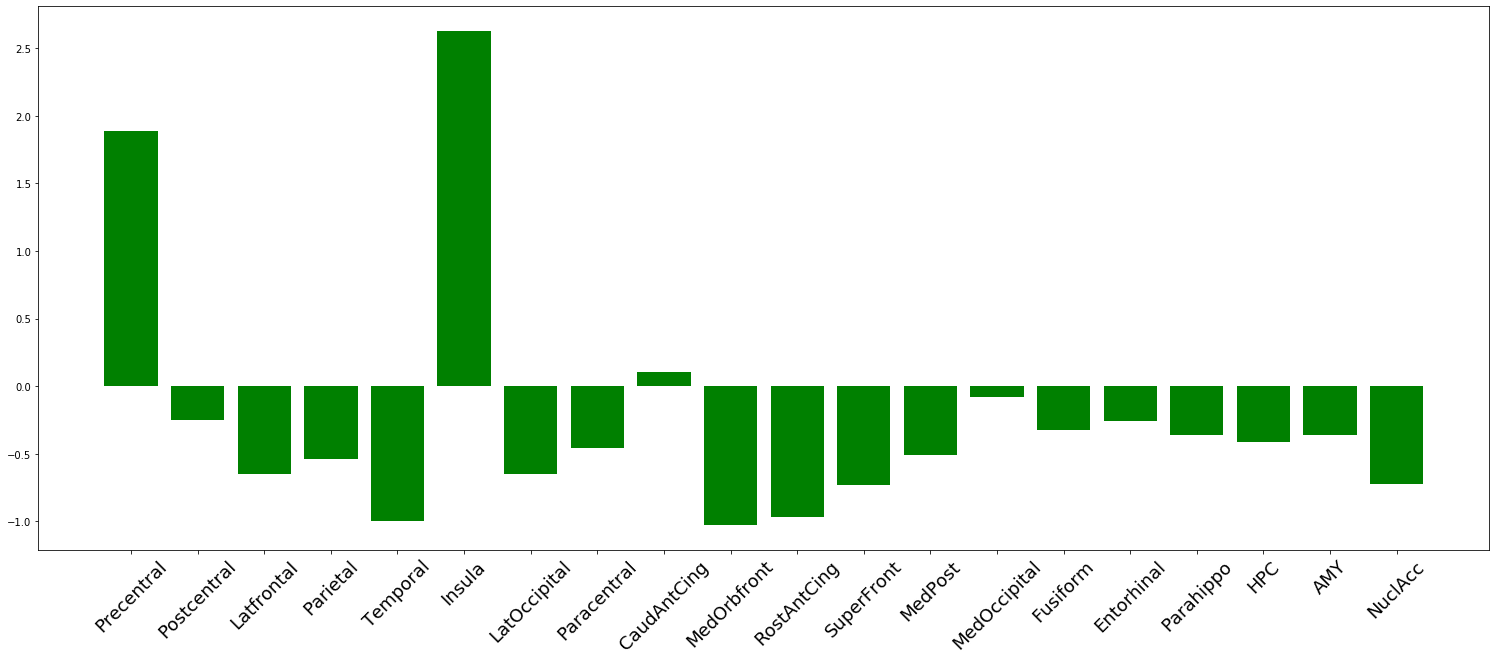

In [22]:
all_thal_features_z_1067 = [1.8865081, -0.25020918, -0.64991844, -0.5367271, -0.99659,
                              2.6272006, -0.65121686, -0.45681167, 0.10836264, -1.0291086, -0.96729654,
                              -0.73409945, -0.5107393, -0.08092461, -0.32473305, -0.25589103, -0.36399293,
                              -0.41195437, -0.36264867, -0.7248616]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1067, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1005**

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictabl

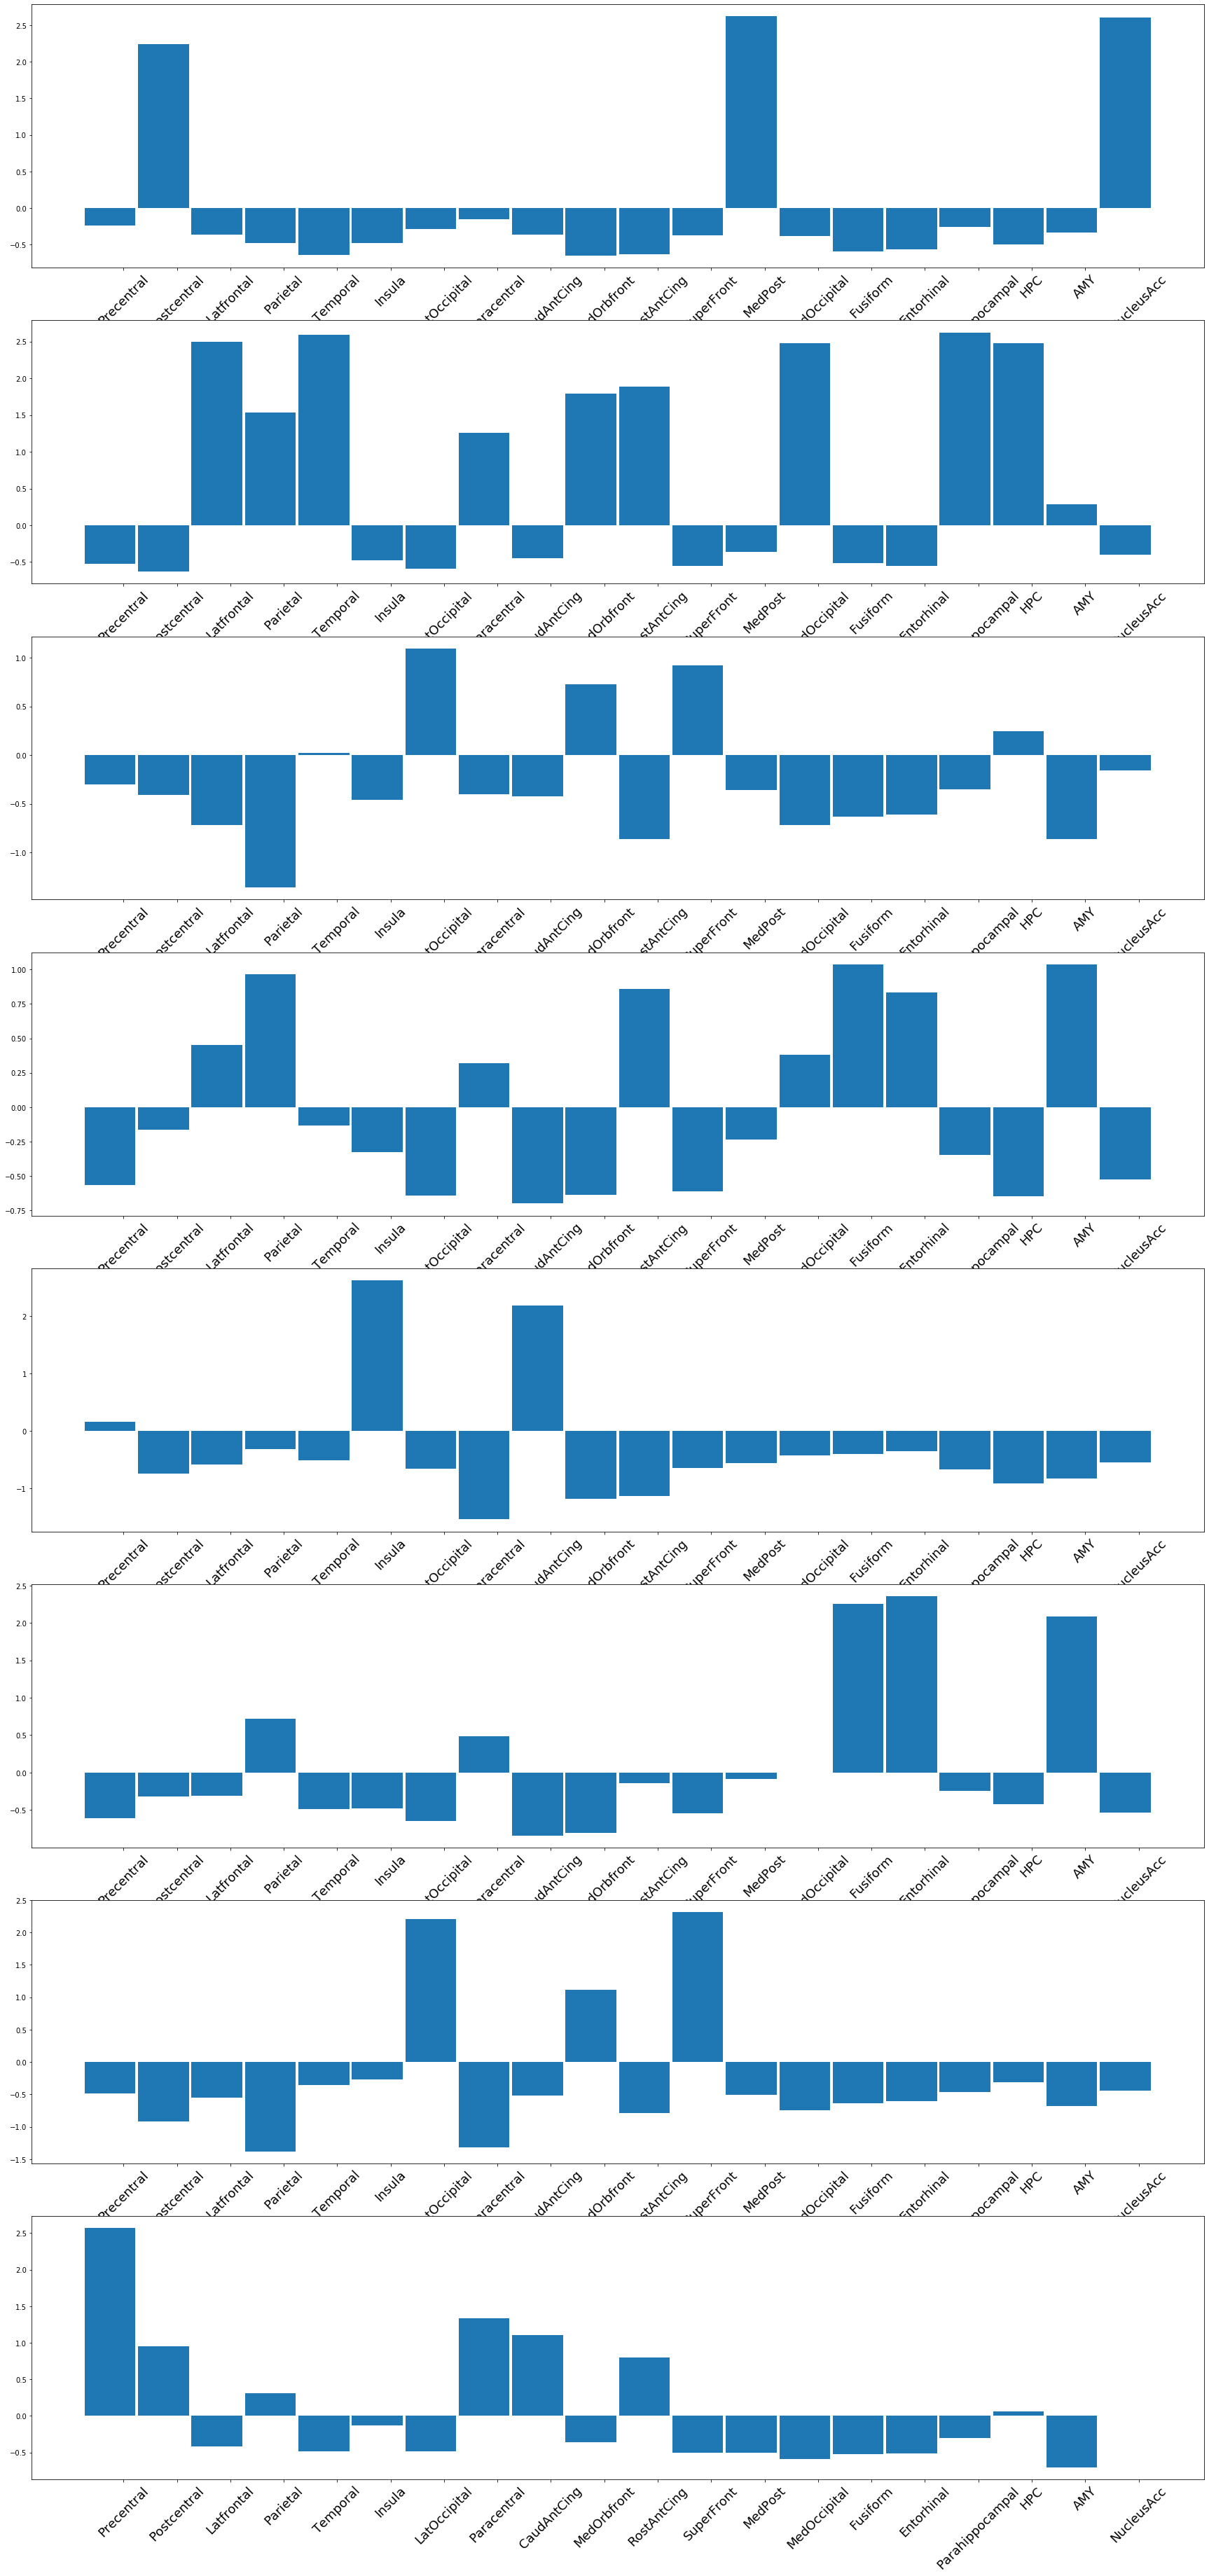

In [10]:
subject_list = ['1005']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [7]:
print(all_thal_features_z[[2]])

[[ 0.16668117 -0.7436653  -0.58757484 -0.3192579  -0.5118745   2.627344
  -0.65432876 -1.5402926   2.1895578  -1.1785033  -1.1303425  -0.6468146
  -0.55271035 -0.4201458  -0.4014152  -0.34837717 -0.6643454  -0.9182006
  -0.8273582  -0.5448167 ]]


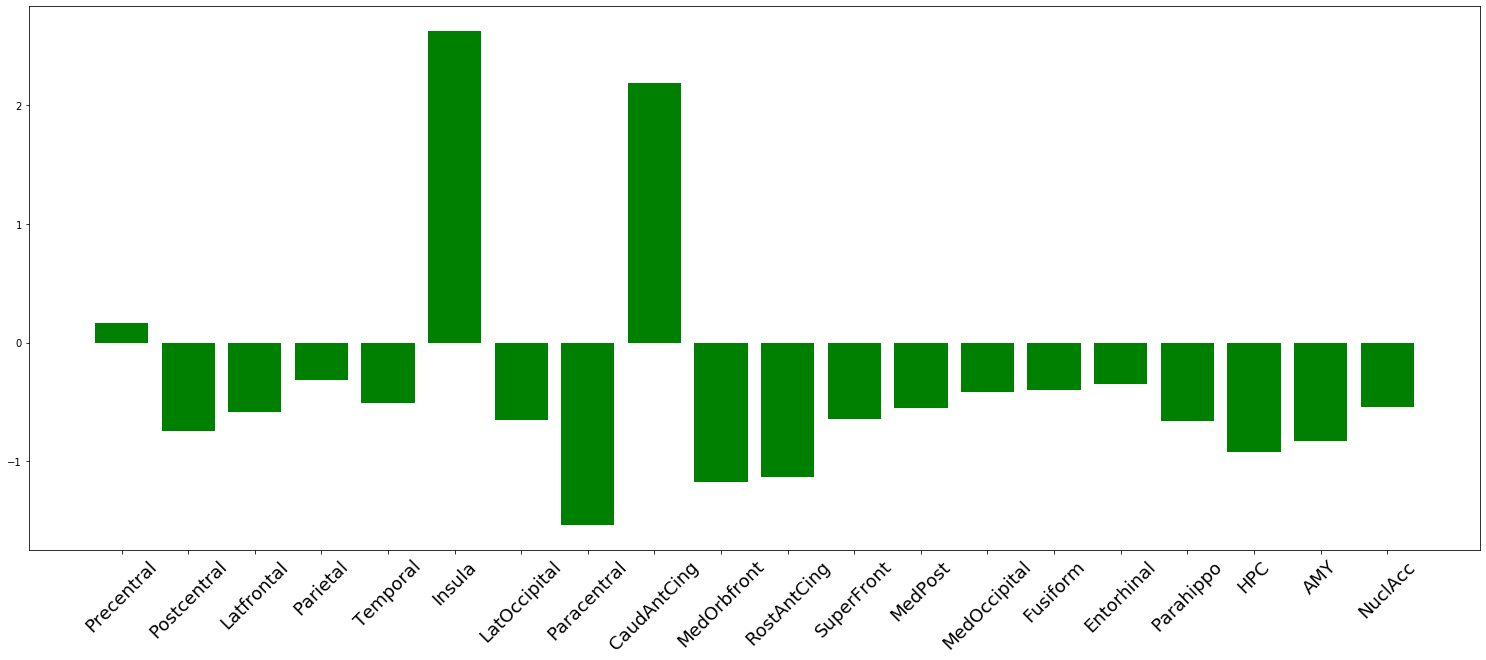

In [24]:
all_thal_features_z_1005 = [0.16668117, -0.7436653, -0.58757484, -0.3192579, -0.5118745,
                              2.627344, -0.65432876, -1.5402926, 2.1895578, -1.1785033, -1.1303425,
                              -0.6468146, -0.55271035, -0.4201458, -0.4014152, -0.34837717,
                              -0.6643454, -0.9182006, -0.8273582, -0.5448167]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1005, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1007**

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictabl

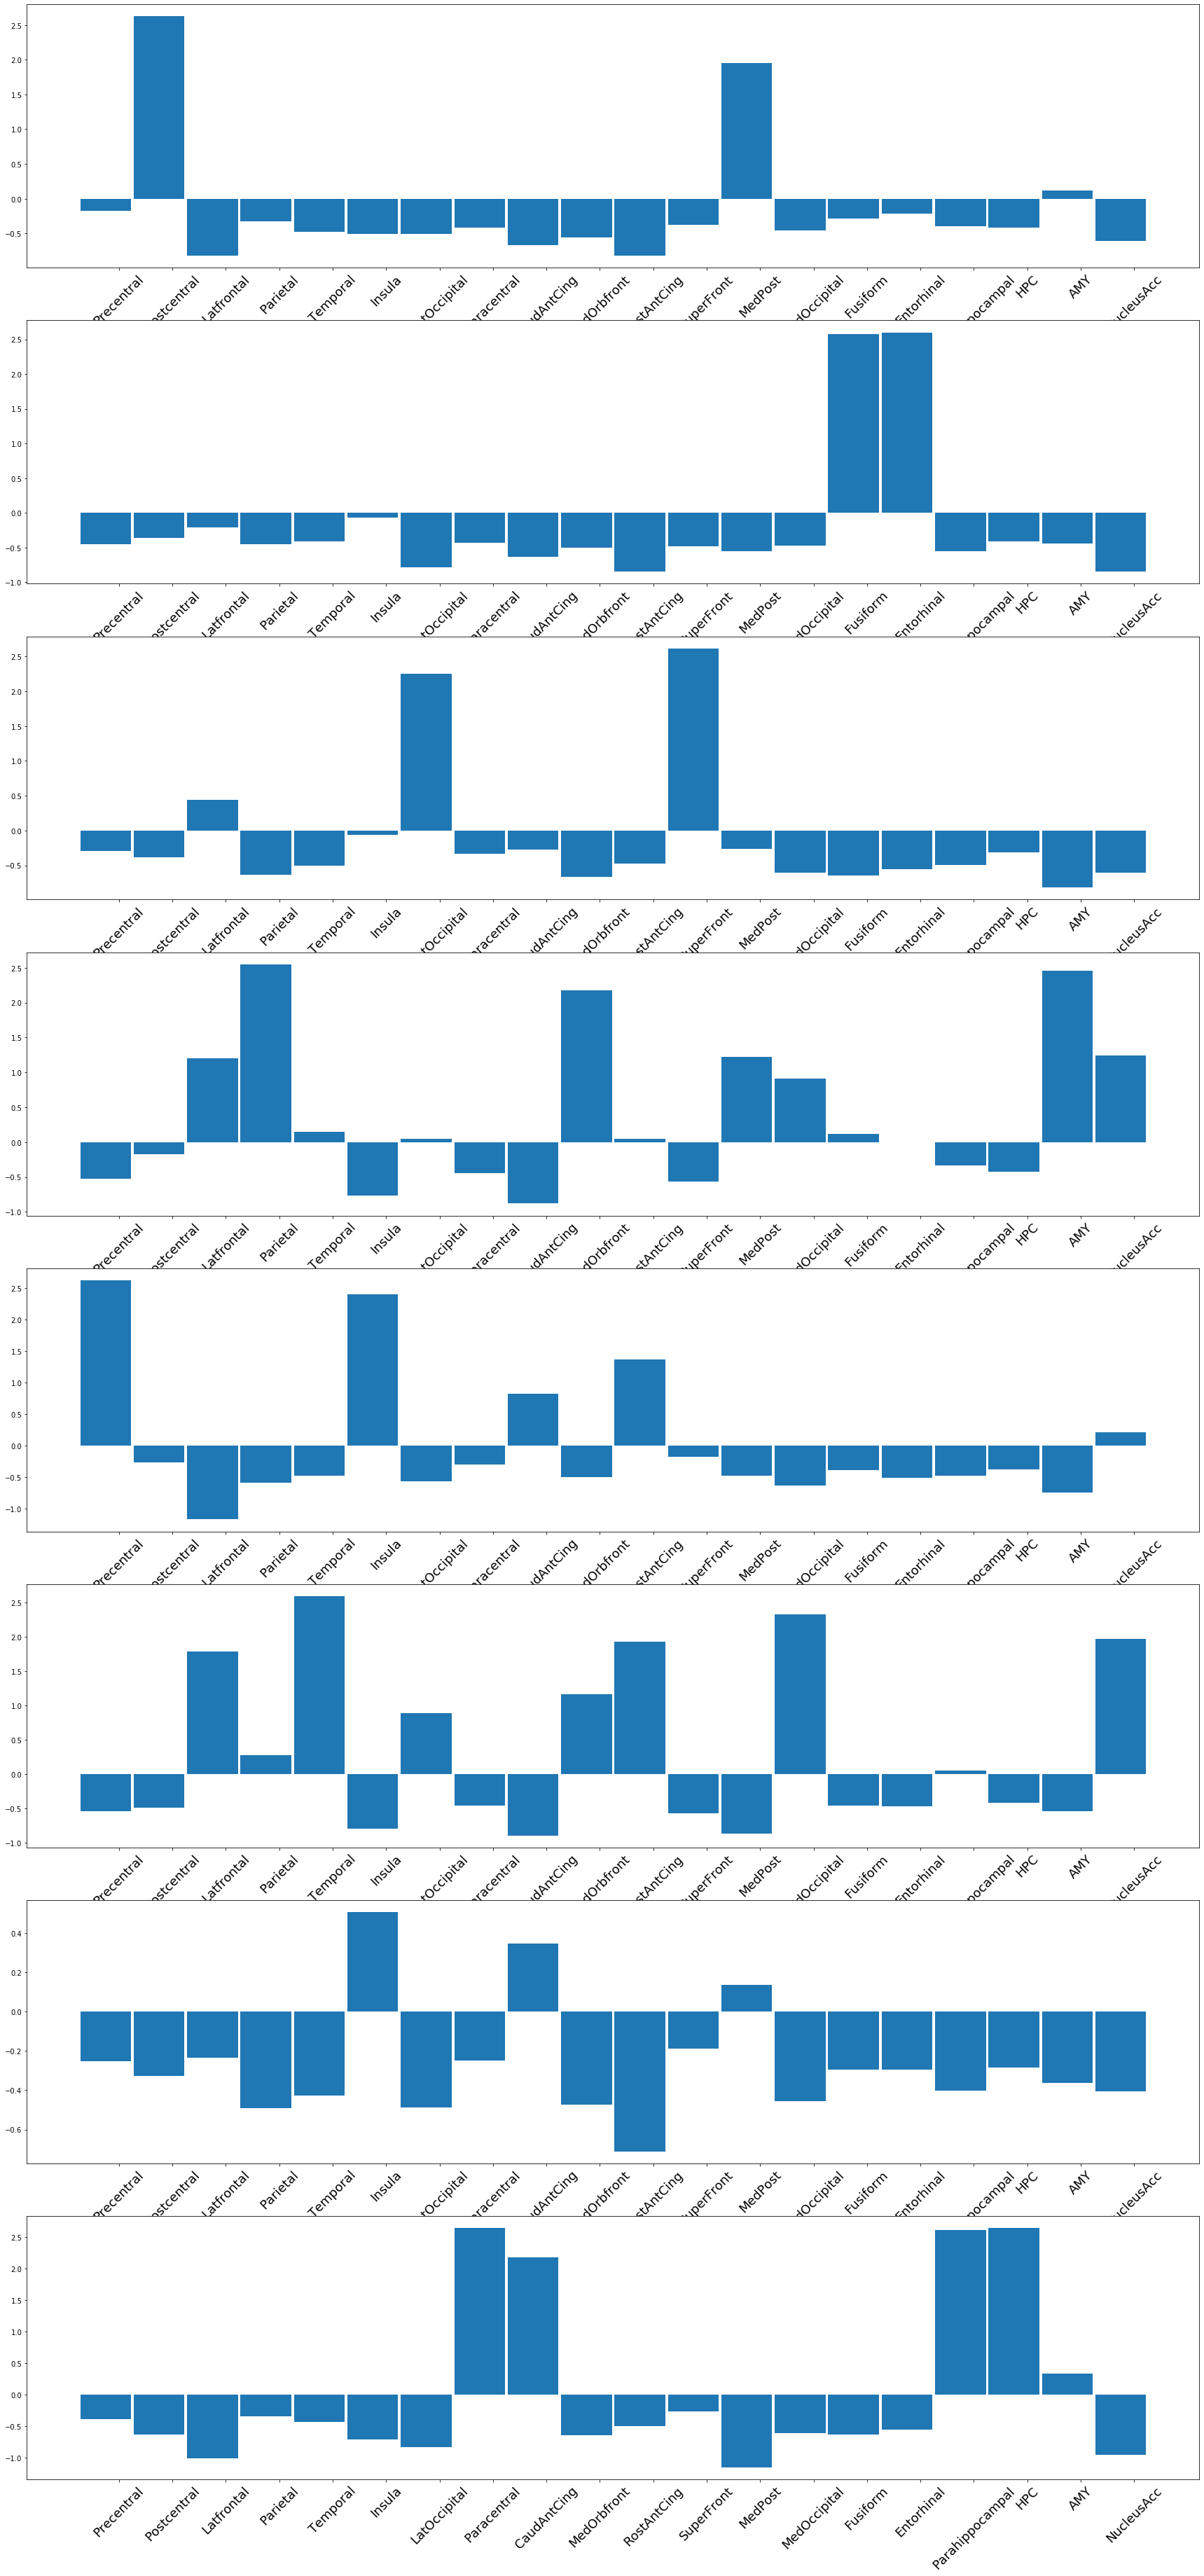

In [11]:
subject_list = ['1007']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [10]:
print(all_thal_features_z[[1]])

[[-0.25001296 -0.33079585 -0.239428   -0.49327752 -0.4248419   0.58118474
  -0.50075686 -0.24736731  0.35035443 -0.47365025 -0.7242383  -0.19336702
   0.1045007  -0.45908687 -0.29293296 -0.29552928 -0.40280017 -0.28522432
  -0.38081285 -0.40990993]]


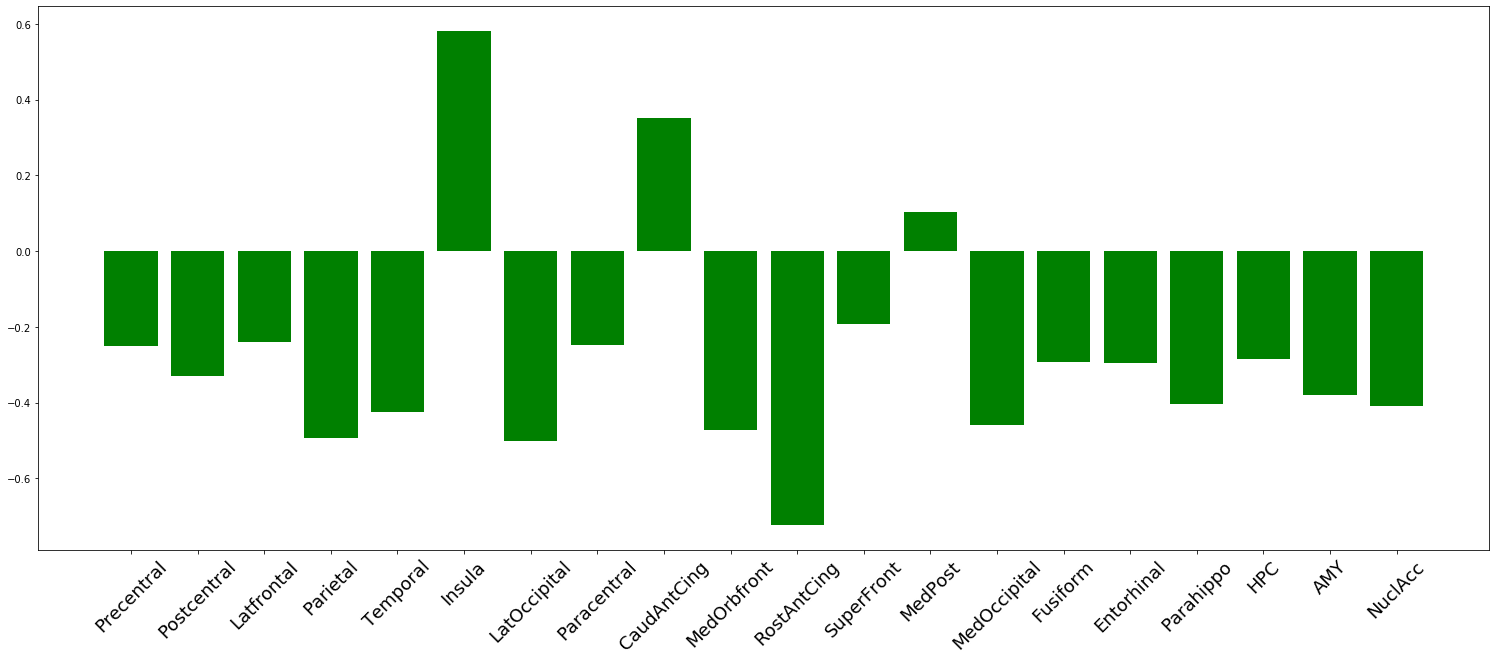

In [26]:
all_thal_features_z_1007 = [-0.25001296, -0.33079585, -0.239428, -0.49327752,
                              -0.4248419, 0.58118474, -0.50075686, -0.24736731,
                              0.35035443, -0.47365025, -0.7242383, -0.19336702, 
                              0.1045007, -0.45908687, -0.29293296, -0.29552928,
                              -0.40280017, -0.28522432, -0.38081285, -0.40990993]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1007, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1027**

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictabl

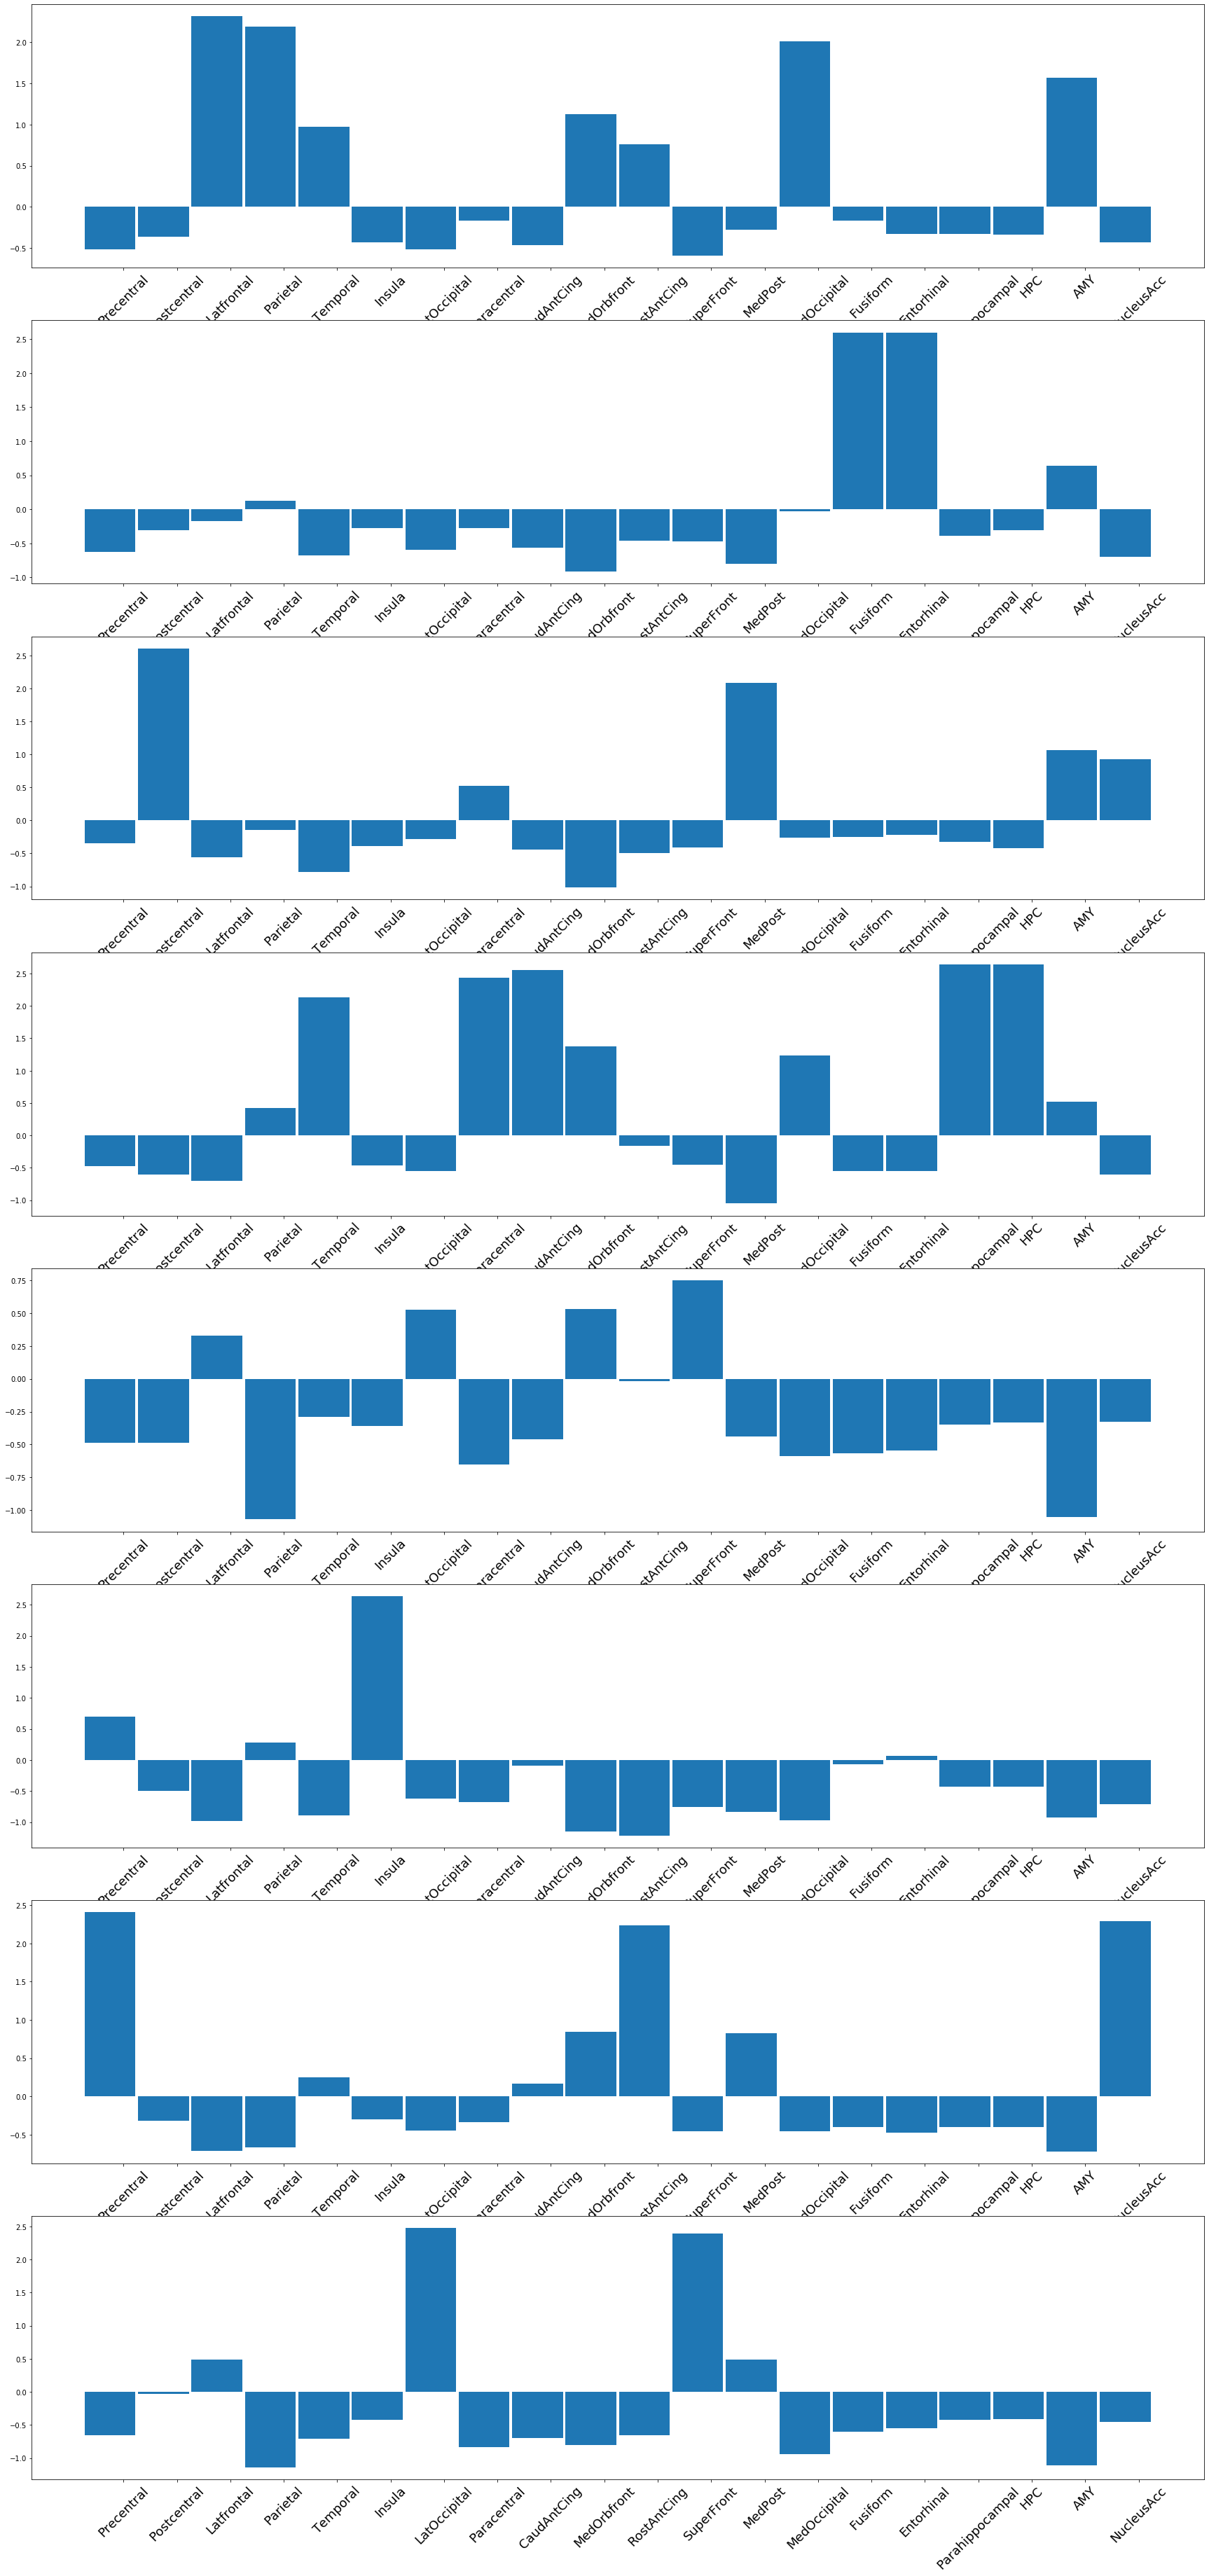

In [12]:
subject_list = ['1027']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [13]:
print(all_thal_features_z[[1]])

[[-0.6288464  -0.30373445 -0.17406102  0.12447993 -0.6728202  -0.2793646
  -0.59623194 -0.2737399  -0.5689539  -0.9163755  -0.46653625 -0.47232077
  -0.77391064 -0.02602504  2.5999827   2.5917237  -0.38971254 -0.30250898
   0.65668553 -0.6972402 ]]


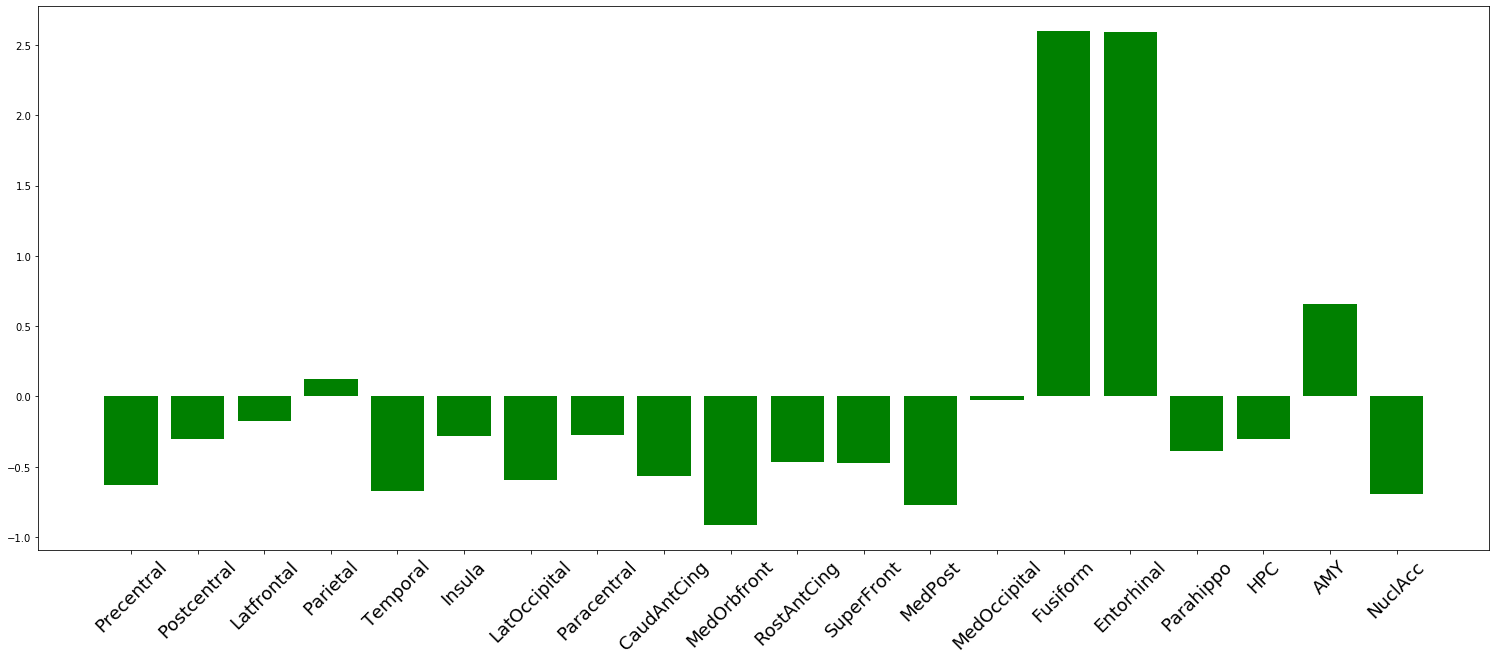

In [32]:
all_thal_features_z_1027 = [-0.6288464, -0.30373445, -0.17406102, 0.12447993, -0.6728202,
                              -0.2793646, -0.59623194, -0.2737399, -0.5689539, -0.9163755,
                              -0.46653625, -0.47232077, -0.77391064, -0.02602504, 2.5999827,
                              2.5917237, -0.38971254, -0.30250898, 0.65668553, -0.6972402]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1027, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1057**

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictabl

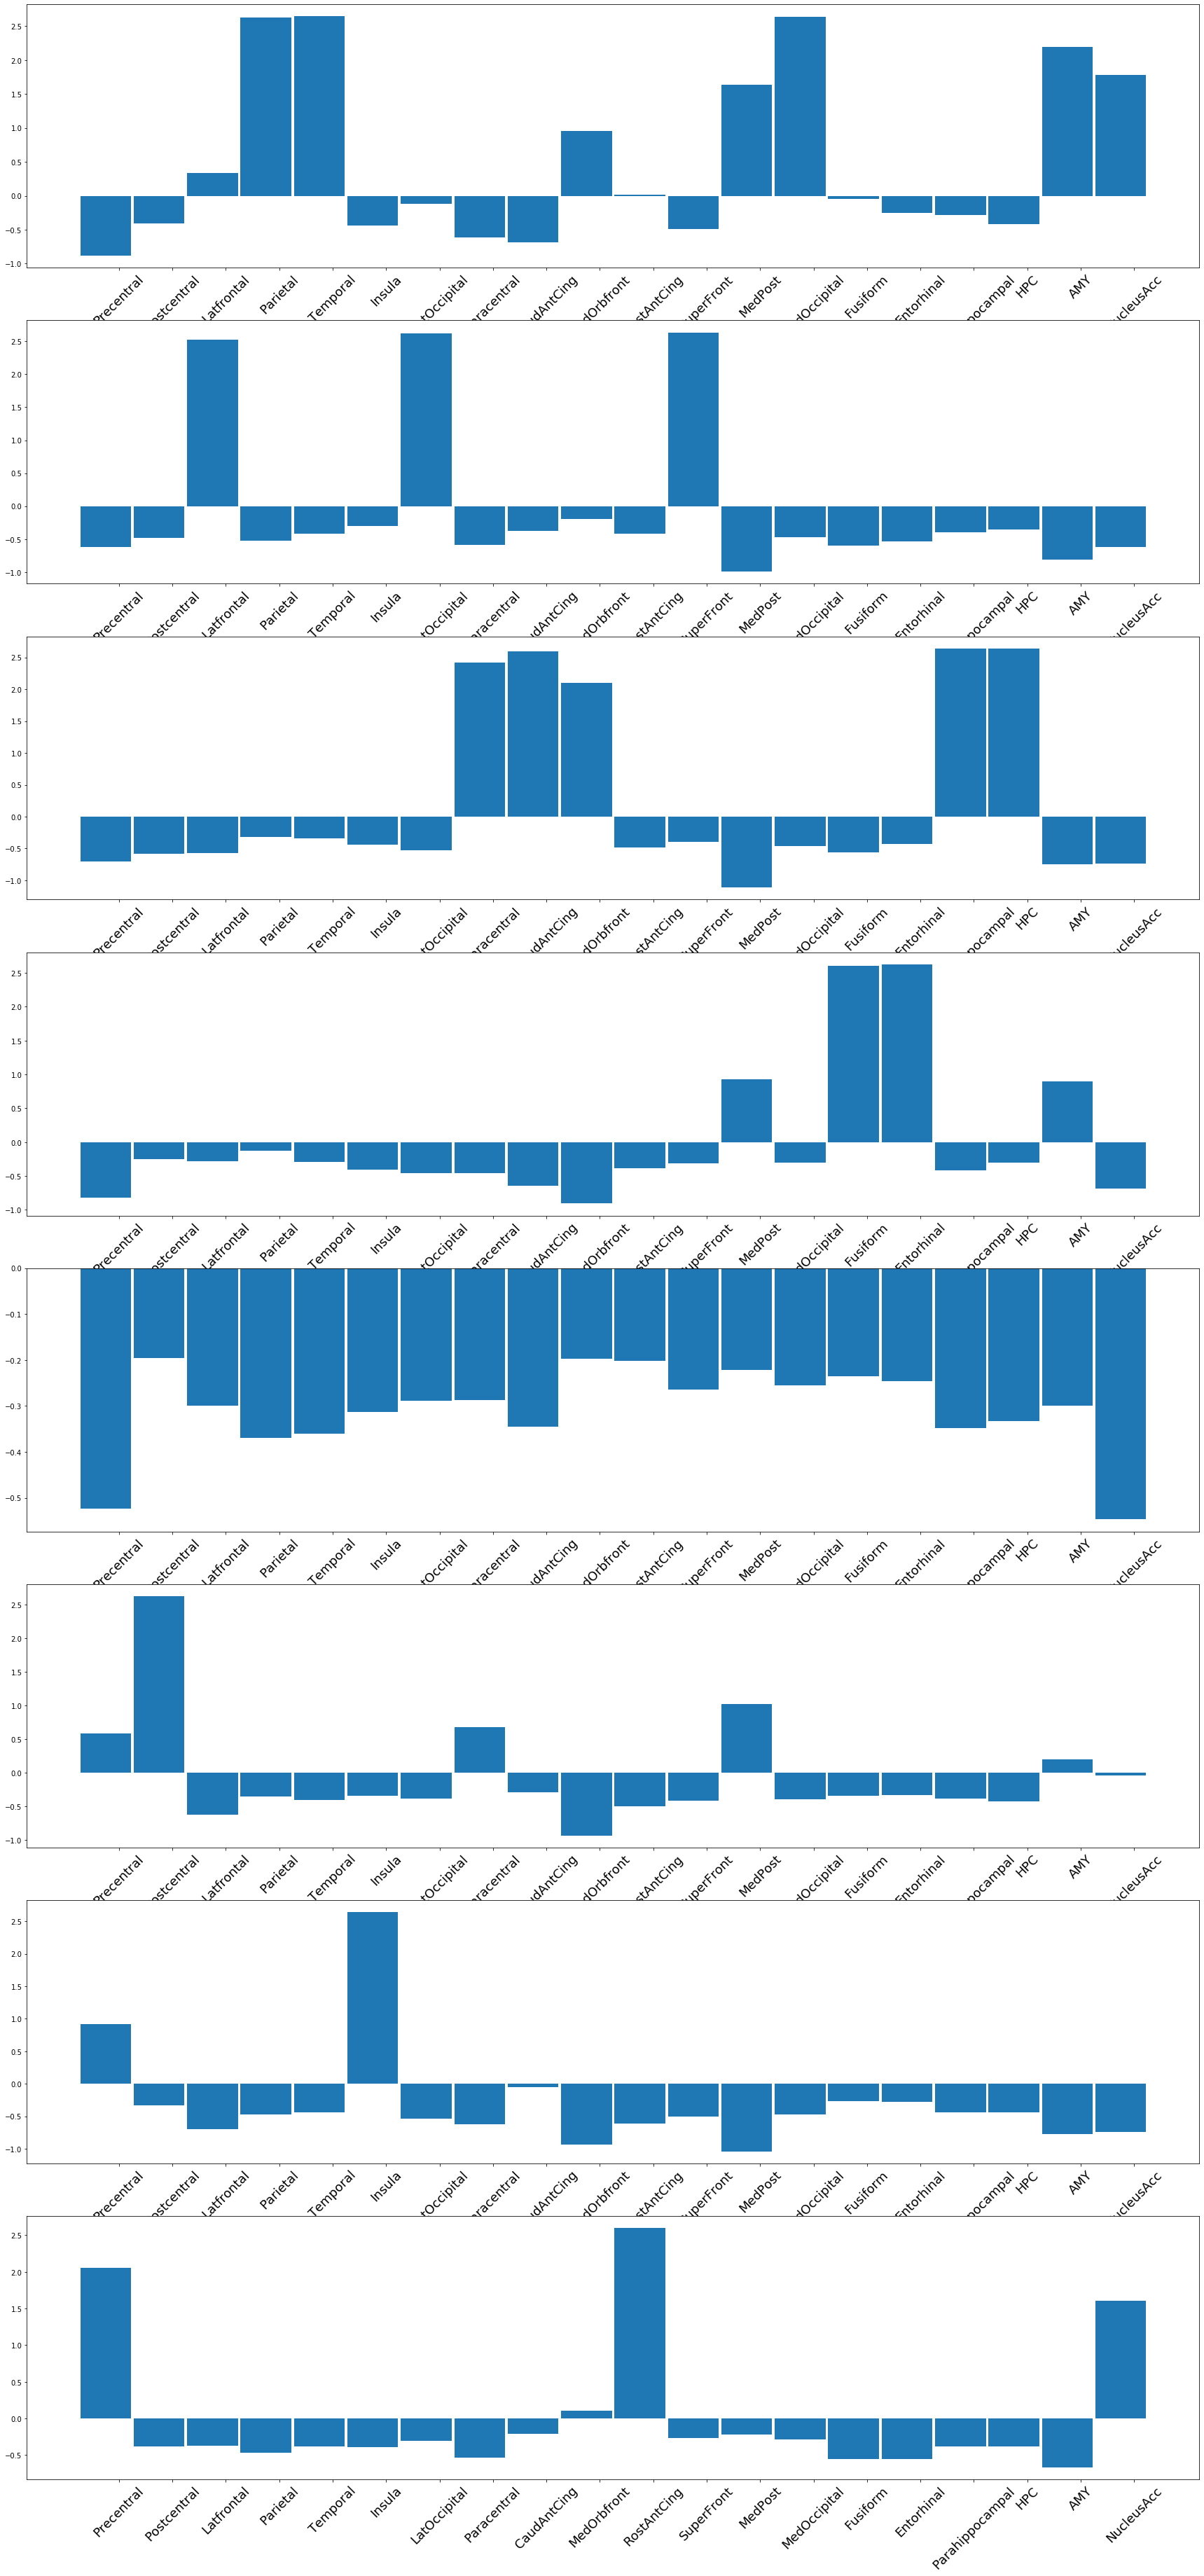

In [13]:
subject_list = ['1057']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [16]:
print(all_thal_features_z[[5]])

[[ 0.9168984  -0.3349994  -0.7017681  -0.4711401  -0.44232786  2.6424153
  -0.5396621  -0.61936176 -0.04689944 -0.93862176 -0.6164822  -0.49912006
  -1.03836    -0.47297886 -0.26653963 -0.28105602 -0.4353687  -0.4350432
  -0.77059317 -0.74518645]]


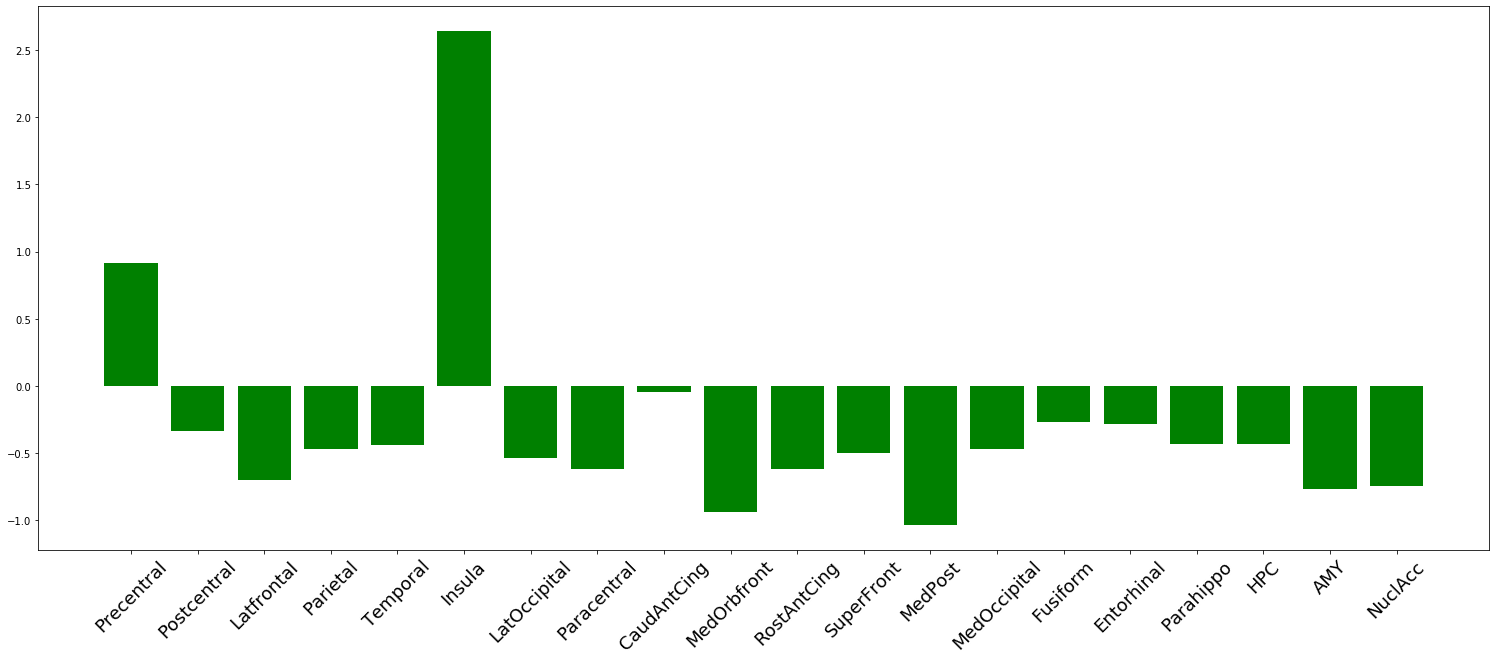

In [29]:
all_thal_features_z_1057 = [0.9168984, -0.3349994, -0.7017681, -0.4711401, -0.44232786,
                              2.6424153, -0.5396621, -0.61936176, -0.04689944, -0.93862176,
                              -0.6164822, -0.49912006, -1.03836, -0.47297886, -0.26653963,
                              -0.28105602, -0.4353687, -0.4350432, -0.77059317, -0.74518645]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1057, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1070**

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictabl

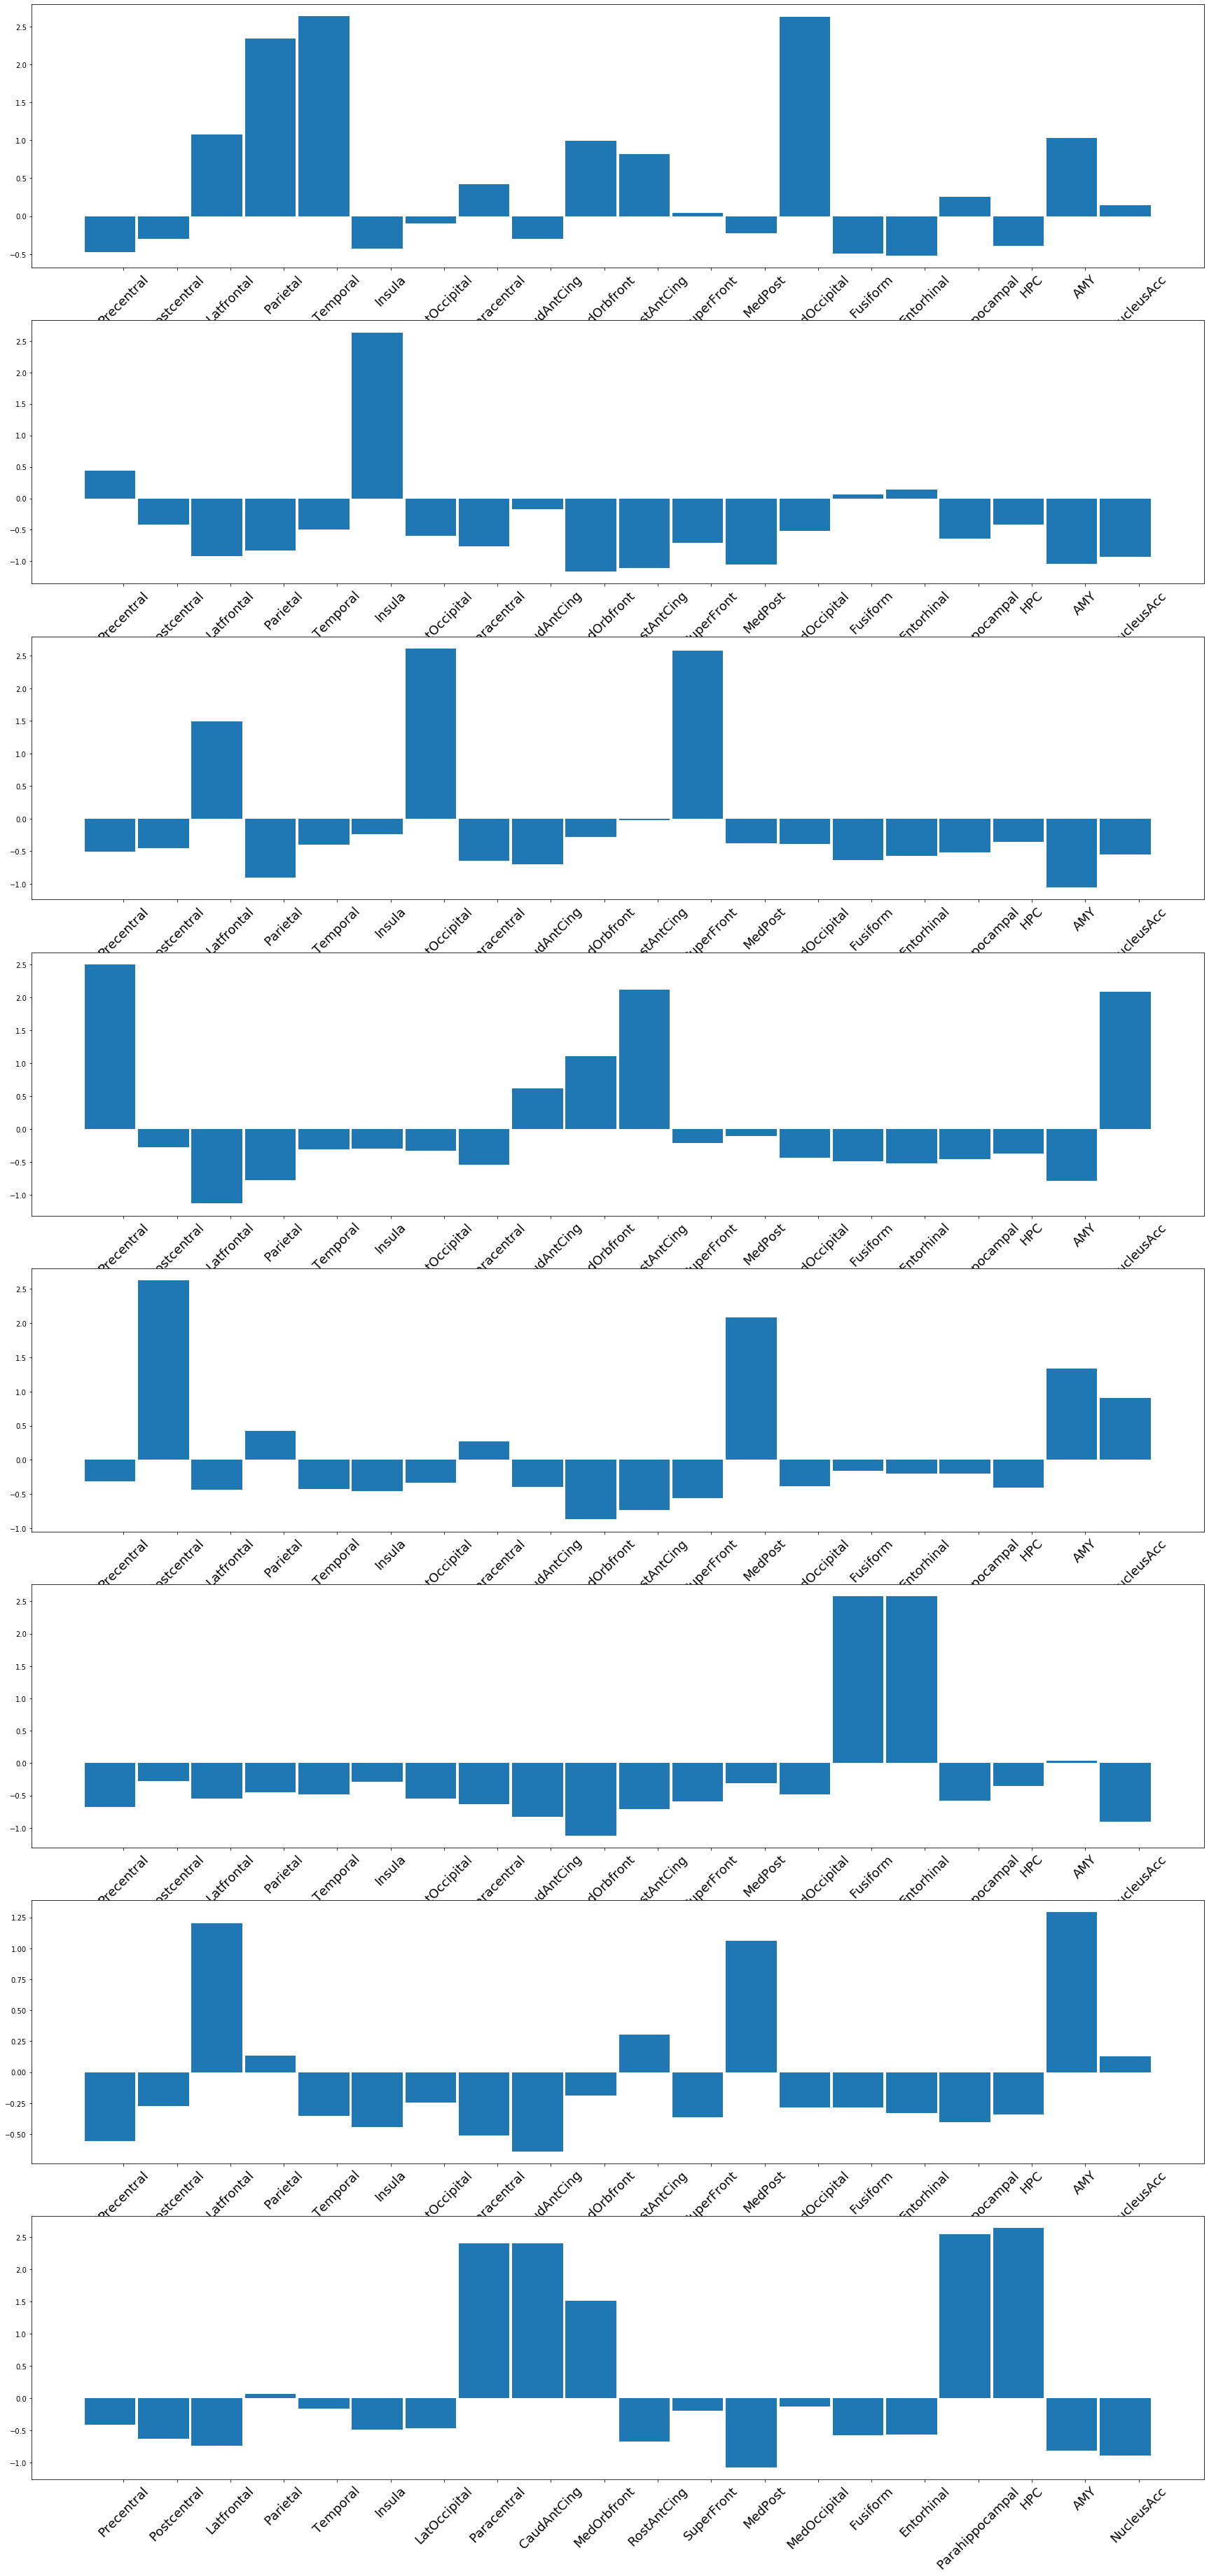

In [14]:
subject_list = ['1070']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [20]:
print(all_thal_features_z[[2]])

[[ 0.22547755  0.06083832 -1.1662128  -1.0106962  -0.61848176 -0.50340724
  -0.38631383 -0.65481615 -0.74279773 -0.807022    1.1592464  -0.30747348
   2.4293196  -0.89199275 -0.64217633 -0.58279246 -0.5271472  -0.40477288
  -0.826307    2.6237695 ]]


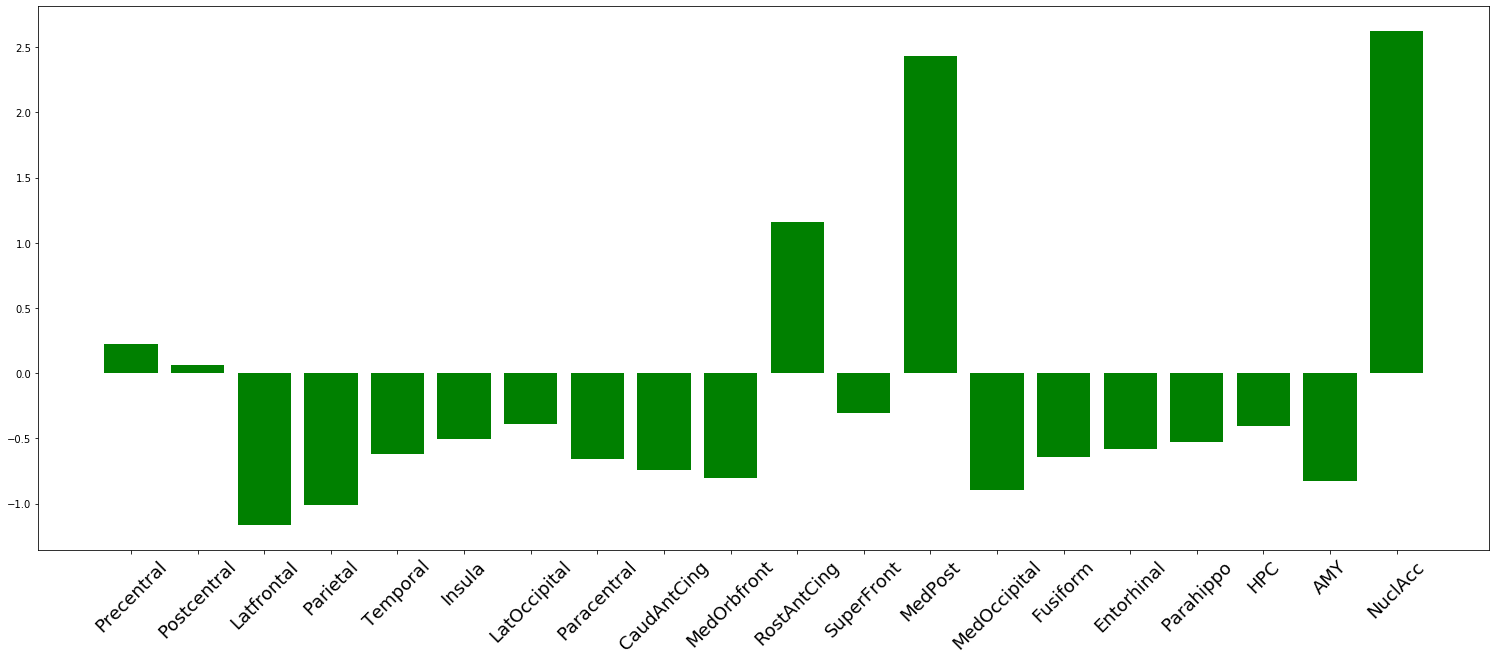

In [28]:
all_thal_features_z_1070 = [0.22547755, 0.06083832, -1.1662128, -1.0106962, -0.61848176,
                              -0.50340724, -0.38631383, -0.65481615, -0.74279773, -0.807022,
                              1.1592464, -0.30747348, 2.4293196, -0.89199275, -0.64217633,
                              -0.58279246, -0.5271472, -0.40477288, -0.826307, 2.6237695]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1070, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1025** 

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictabl

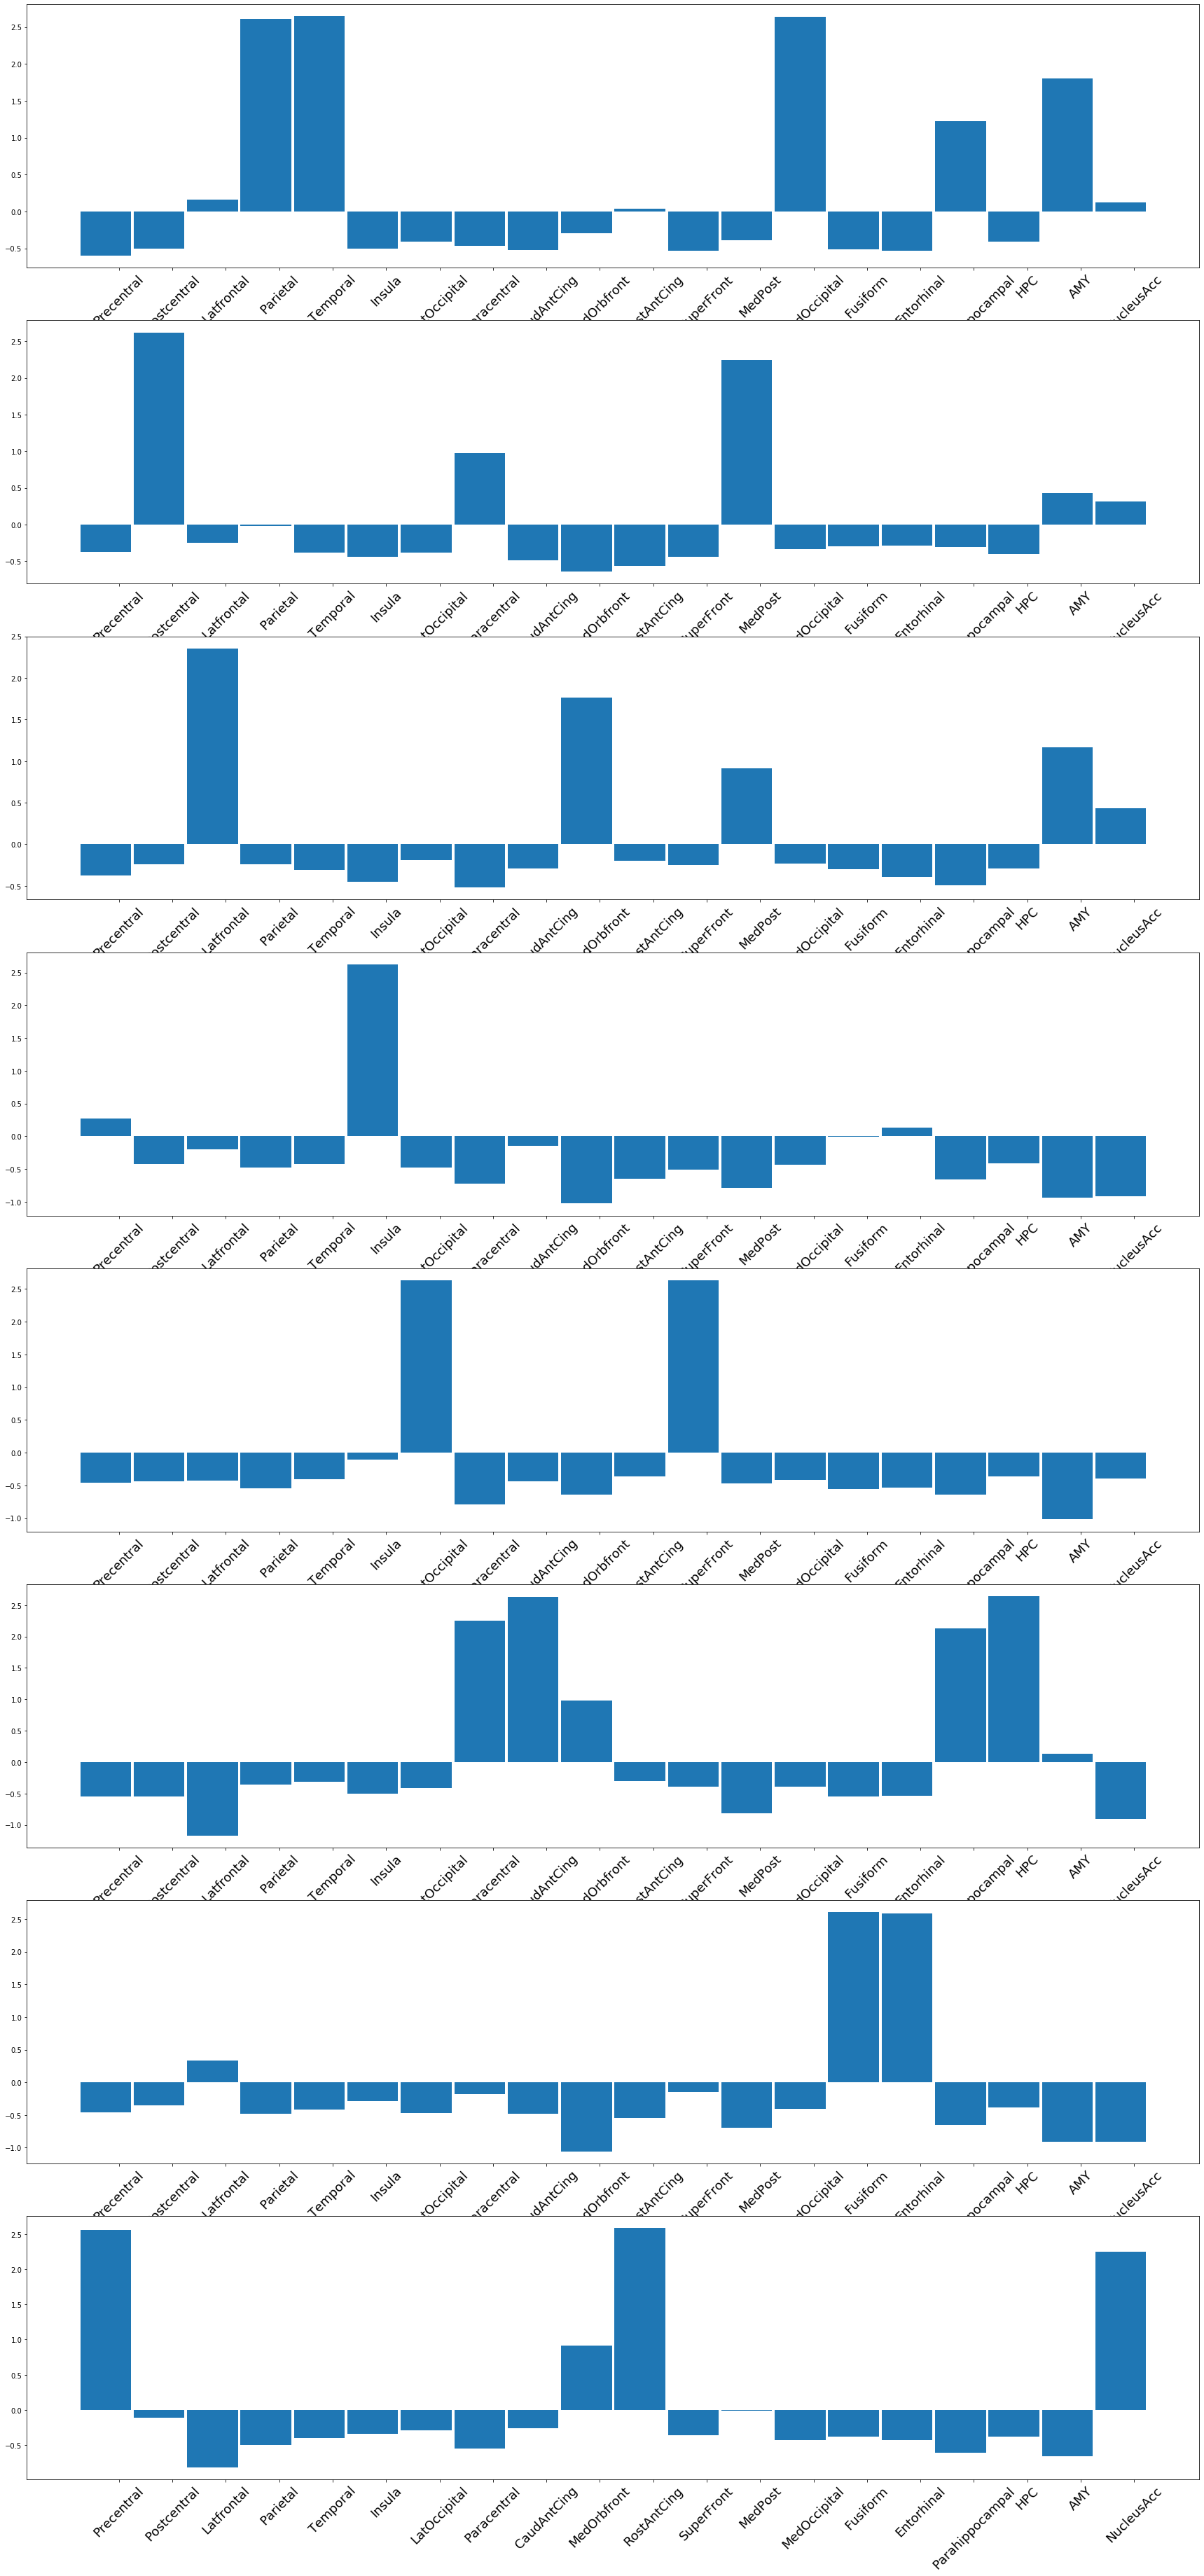

In [15]:
subject_list = ['1025']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [23]:
print(all_thal_features_z[[1]])

[[-0.46135876 -0.34748942  0.33832175 -0.48265627 -0.41765478 -0.29014364
  -0.47266763 -0.18013981 -0.47626647 -1.0550807  -0.54965895 -0.14967133
  -0.6984921  -0.4046384   2.6073556   2.5888143  -0.65255636 -0.38128266
  -0.9097497  -0.90569204]]


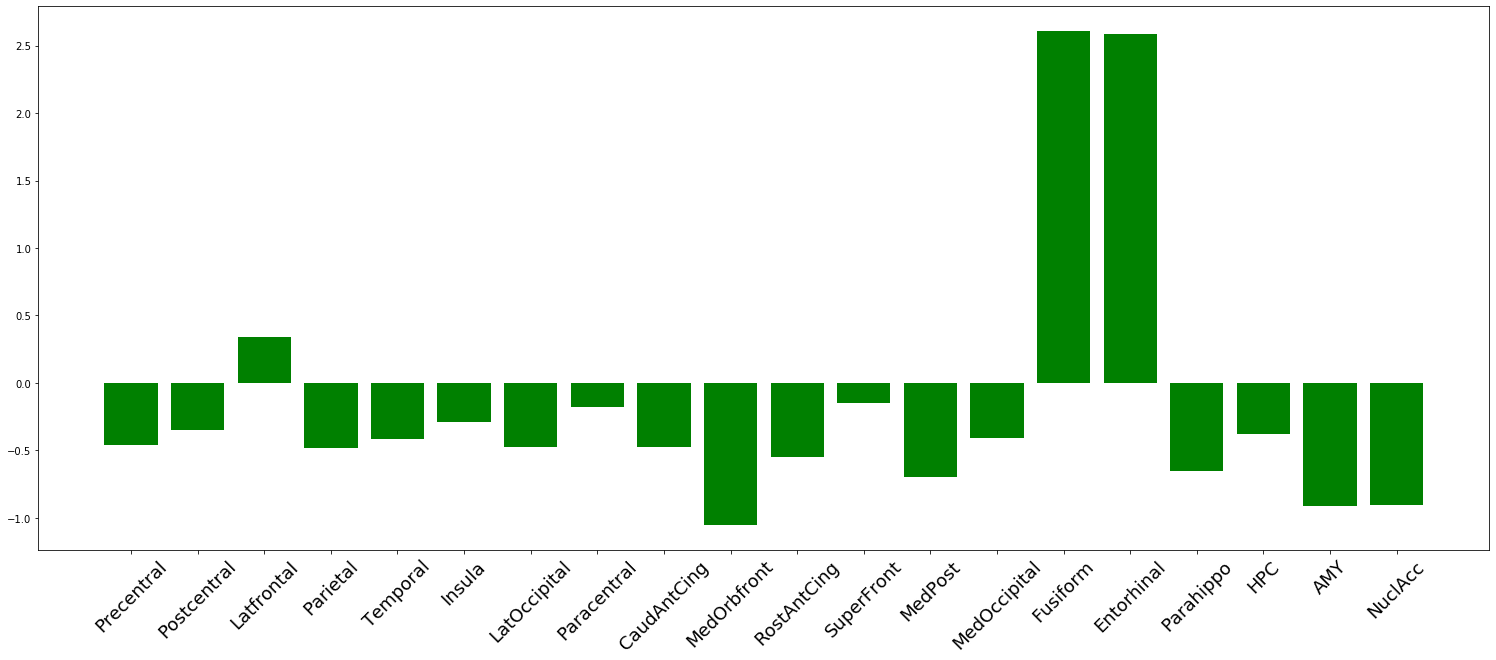

In [30]:
all_thal_features_z_1025 = [-0.46135876, -0.34748942, 0.33832175, -0.48265627, -0.41765478,
                              -0.29014364, -0.47266763, -0.18013981, -0.47626647, -1.0550807, -0.54965895,
                              -0.14967133, -0.6984921, -0.4046384, 2.6073556, 2.5888143, -0.65255636,
                              -0.38128266, -0.9097497, -0.90569204]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1025, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**All Midline_thal Clusters**

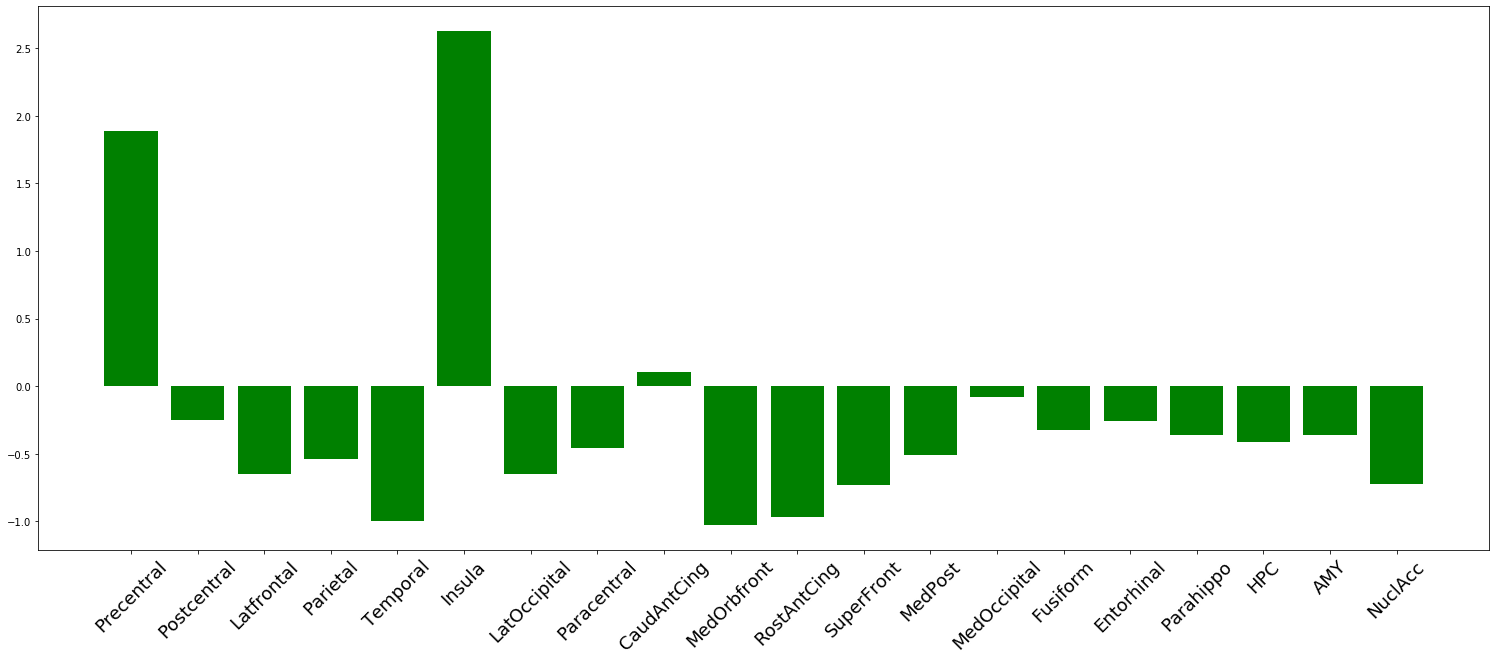

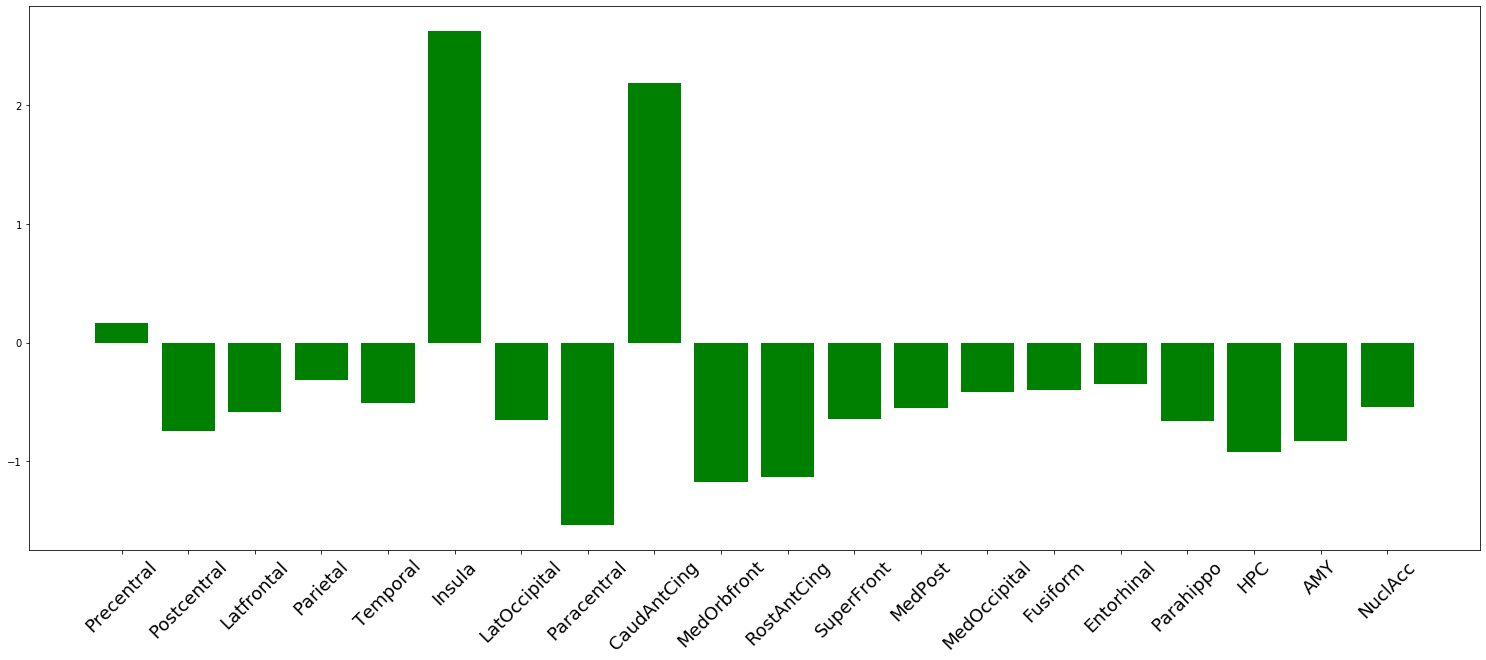

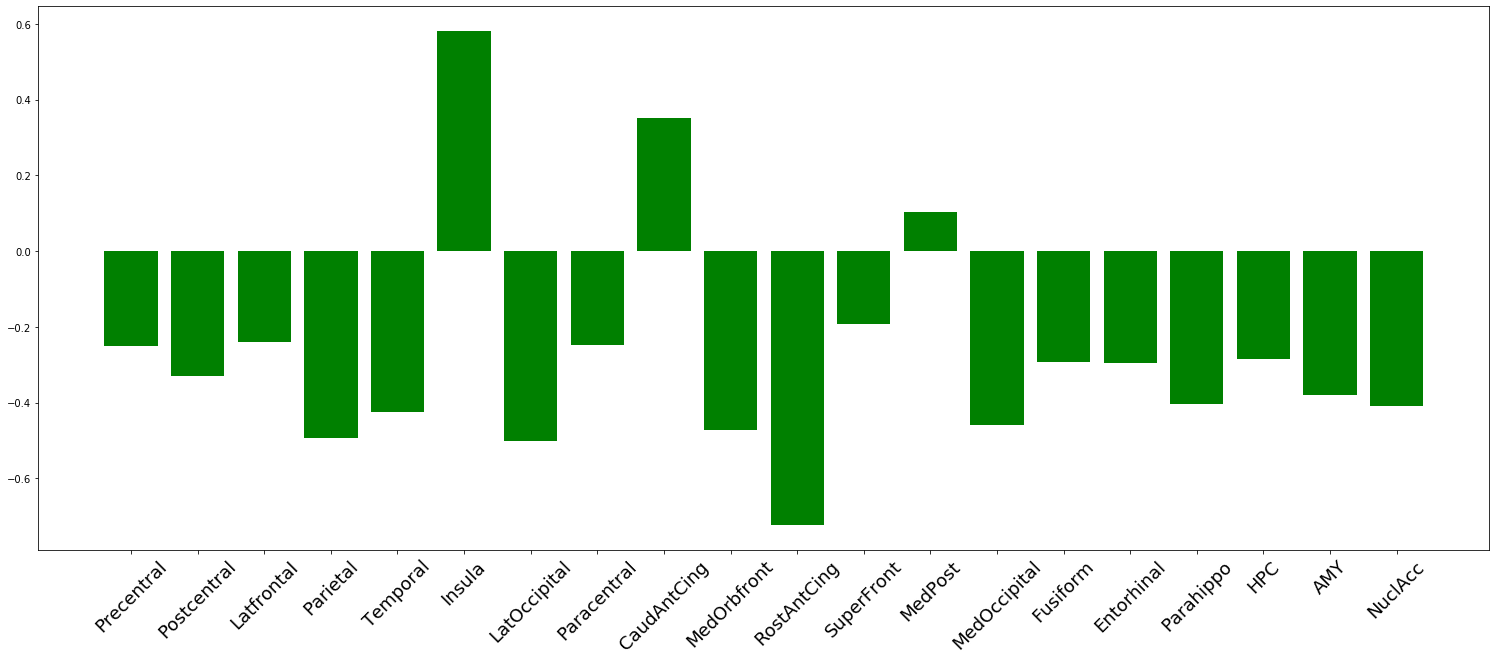

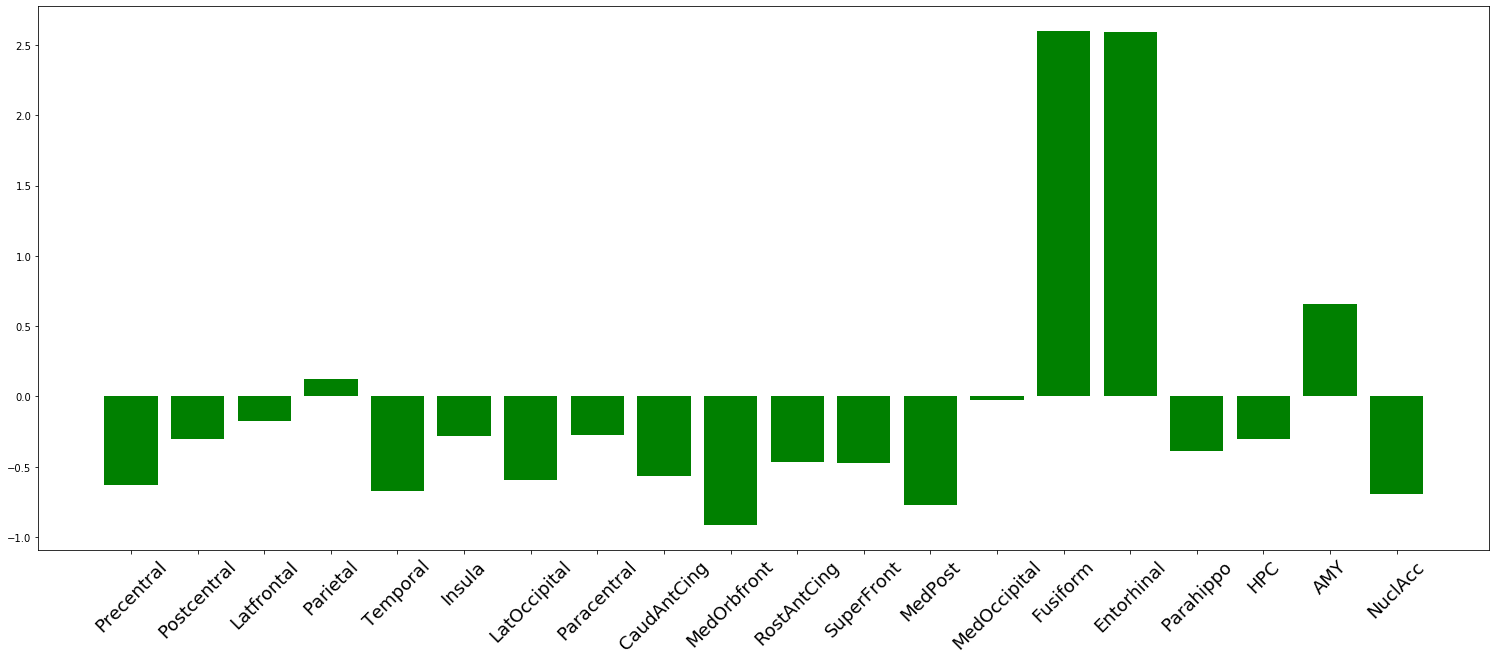

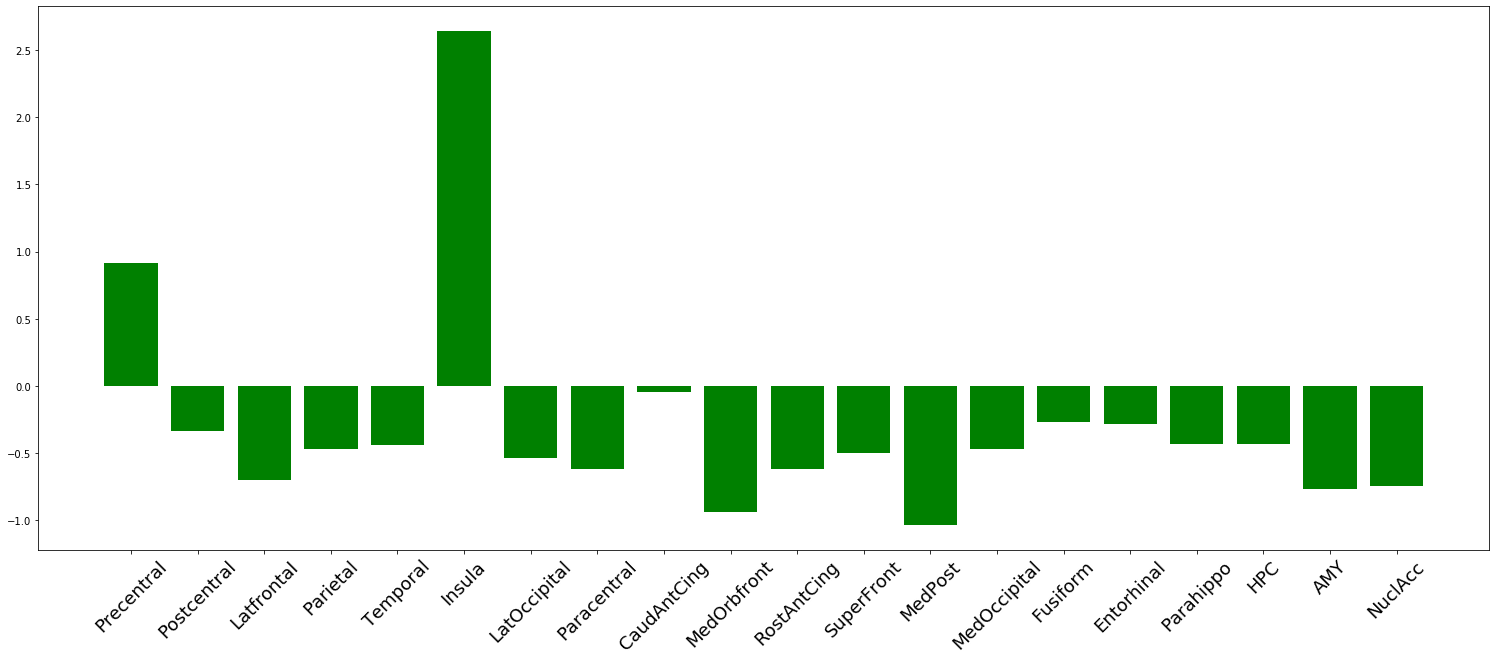

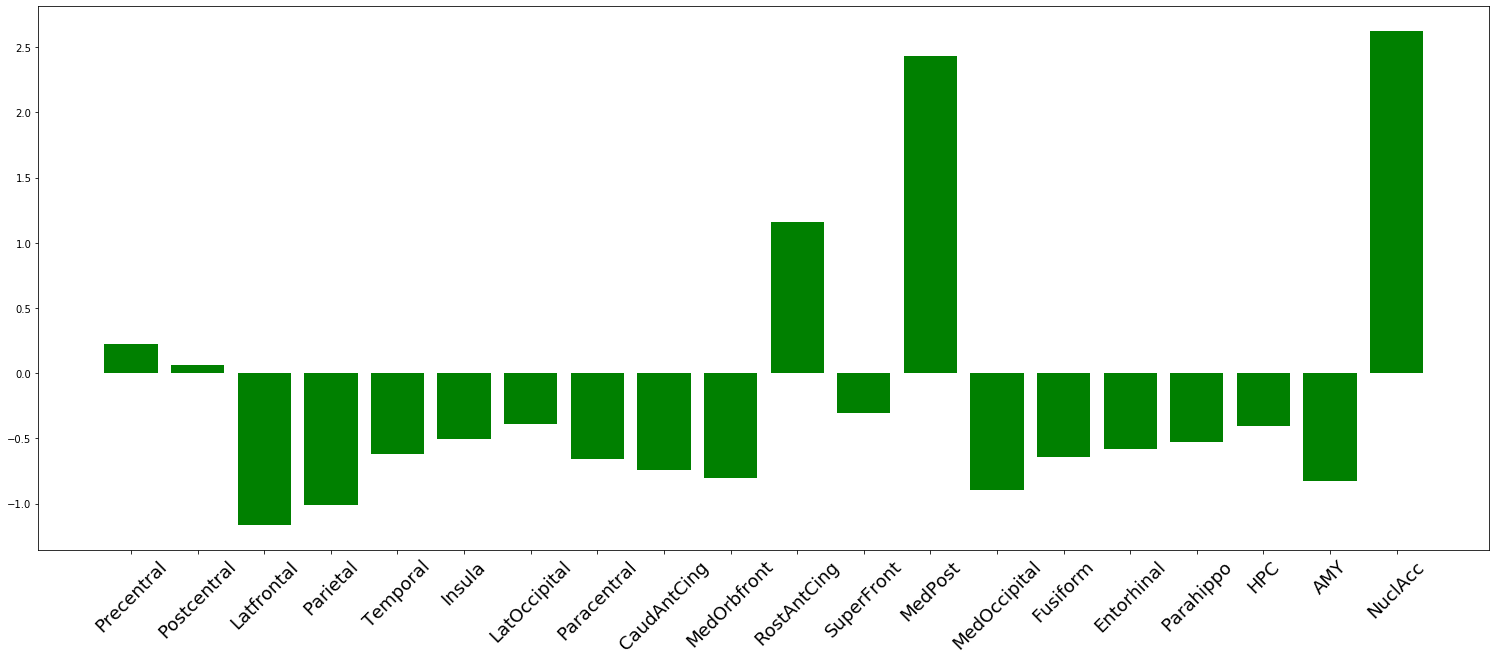

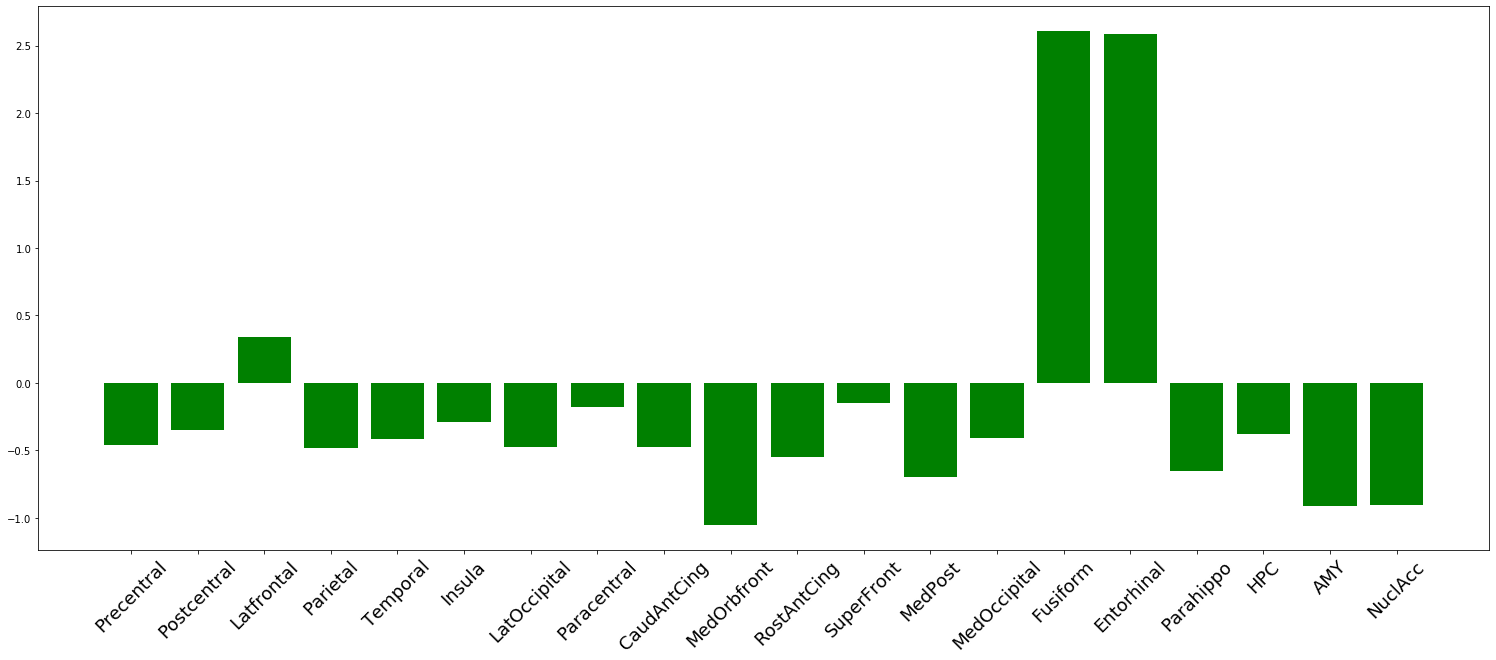

In [33]:
#1067
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1067, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1005
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1005, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1007
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1007, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1027
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1027, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1057
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1057, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1070
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1070, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1025
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1025, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

plt.show()